Vtuber Superchat Data Analysis - A Data Science Pipeline Tutorial
==========================

# Table of Contents
1. [Introduction](#intro)
    1. [What are Vtubers?](#what)
    2. [Why care?](#why)
2. [Data Collection](#datacollect)
    1. [Part 2 - Scraping](#scrape)
3. [Data Management and Representation](#dmr)
4. [Exploratory Data Analysis](#eda)
    1. [Correlation between time of day and superchats](#tod)
        1. [Findings](#tdss)
        2. [Possible Future Work](#tdspfw)
    2. [Correlation between view count and superchats](#vc)
        1. [Regression Warning](#pitfall0)
        2. [Residuals Warning](#pitfall1)
        3. [Video Game Streams](#vgs)
        4. [Findings](#vcsumm)
5. [Machine Learning](#ml)
6. [Summary/Conclusions](#summ)
7. [Possible Future Work](#pfw)

# Introduction<a name="intro"></a>

## What are Vtubers?<a name="what"></a>

[Vtubers](https://en.wikipedia.org/wiki/Virtual_YouTuber), short for "Virtual Youtubers," are internet personalities who use virtual avatars (usually using anime-style avatars, which can be animated in [Live2D](https://www.live2d.com/en/), 3D, both, or neither). Originally mostly popular in Japan, in recent years they have become more popular overseas, to the point that many westerners and "normal streamers" have adopted Vtuber personas themselves.

The Vtuber industry has explosively grown in the last 2-3 years, with entire agencies such as [Hololive](https://en.hololive.tv/) and [Nijisanji](https://www.ichikara.co.jp/en/service-nijisanji/) being formed to manage and promote their Vtubers.

As stated on Wikipedia, YouTube's 2020 Culture and Trends report highlights VTubers as one of the notable trends of that year, with 1.5 billion views per month by October.

In summary, if you are familiar with Twitch streamers, you can think of Vtubers as similar personas but with anime avatars instead of showing their physical selves on camera.

![Hololive Vtuber Hoshimachi Suisei (left) playing Minecraft with fellow Vtuber Shiranui Flare (right)](./images/vtuber_minecraft.png)

<!-- <iframe width="1253" height="705" src="https://www.youtube.com/embed/1endAJC_CC8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe> -->

![stats](https://pbs.twimg.com/media/EpTQi1dWEAgVyYX?format=jpg&name=medium)

These Vtubers primarily make money through memberships where viewers can pay to get certain perks, and through [superchats](https://creatoracademy.youtube.com/page/lesson/superchat-and-superstickers_what-is-superchat_video) where users can pay money to highlight their message. (Joining a membership can also have a message associated with it, so they are classified as superchats as well). This is big business - at my time of writing (5/1/2021), 15 of the top 20 most superchatted channels worldwide were those of Vtubers (https://playboard.co/en/youtube-ranking/most-superchatted-all-channels-in-worldwide-total). Furthermore, the top Vtubers make upwards of \\$1,000,000 USD in superchat revenue in 2020, and the top 193 channels all made over \\$100,000 USD (again, many of whom were Vtubers). (Of course, not all of this money goes directly to the Vtuber - YouTube themselves, and the agency the Vtuber works for \[if any\], both take a cut).

In this project, I aim to analyze the superchat earnings of various Vtubers, and hope to see if I can find any trends or indicators that might correlate with higher superchat earnings. 

## Why care?<a name="why"></a>

As stated earlier, Vtubers are a growing business (from 2000 active Vtubers in May 2018 to over 10,000 in January 2020), and there are many people who hope to become Vtubers. The industry is so profitable that agencies have been formed to manage them. Both current and aspiring Vtubers thus stand to gain from knowing how to maximize their superchat earnings, or predict how much they might make based on how they plan to stream. This analysis aims to provide insight into both of those aspects. For fans, I feel that knowing this data is interesting in and of itself, and others have done studies regarding vtubers for fun. For example, one reddit user conducted a study of [the languages used in various vtubers' chats](https://www.reddit.com/r/Hololive/comments/l2f9en/which_member_gets_the_most_english_chat_messages/). I hope to also post this study to reddit and get gilded.

This study could also probably be extended to non-vtuber streamers, to potentially increase the audience for who finds this data useful.

For non-vtuber fans (and vtuber fans too!), you might learn about the data science pipeline, ranging from data collection to exploratory data analysis to some regression with machine learning.

# Data Collection<a name="datacollect"></a>

Of course, the first thing we need to do is collect the data we want to analyze. To my knowledge, no such dataset on Vtuber superchat data (publicly) exists, so we need to create it ourselves. To do this, we will use a combination of the [Youtube Data API](https://developers.google.com/youtube/v3), web scraping, and the [`chat-downloader`](https://github.com/xenova/chat-downloader) library (`pip install chat-downloader`) (this tool also seems to do web scraping in the background).

For the dataset, I picked 50 different VTubers, most of which were under the Vtuber talent agency Hololive (because they are by far the most popular agency), but also with some from other agencies and also a few independent Vtubers. The selection was not exactly scientific; I mostly just chose VTubers I liked or had heard of before, but made sure to get some spread in their popularities/subscriber counts. Of each VTuber, I would attempt to retrieve data of their last 50 videos. However, only livestreams with live chat replay would be counted towards the data, so this resulted in closer to an average of 45 videos per Vtuber (for a total of over 2200 individual videos). To start, some data on each of the 50 Vtubers - their anglicized name, group affiliation, and channel ID - was manually populated into a CSV. 

Next, some functions were created to facilitate the collection of data.

`get_superchats` would return timestamps of each superchat, paid sticker message, or membership message (each of which is paid, and classified as a superchat), as well as a sum of the dollar value of said superchats for a given video URL. This function actually takes a while to run (on the scale of minutes to almost an hour per video, depending on the video's length)

Unfortunately I did not have the foresight to retain the currency data or the individual dollar values of each superchat.

`get_last_50_videos` will return a list of the last 50 videos for a given vtuber's channel, of which the return value will be fed into `get_all_vids_details` and subsequently `get_video_details` to return some metadata for each video.

The data we will be logging are the following fields:

| Field       | Description | Ended up being used |
| :---------- | :---------- | :--- |
| `video_name`| The title of the video       |      |
| `video_id`  | Youtube's id for the video        |   &check;   |
| `description`  | The description of the video, as written by the Vtuber        |      |
| `published_at`  | Youtube's id for the video        |  &check;    |
| `video_start_time` | The time at which the livestream actually started |  &check; |
| `video_end_time` | The time at which the livestream actually ended | &check;  |
| `num_superchats` | The amount of individual superchats received in a video | &check;  |
| `val_superchats` | The total value of superchats received in a video, in USD | &check; |
| `locale` | Supposedly the language in which the video was made, but seems inaccurate |    |
| `viewcount` | The number of views the video received.<sup>1</sup> | &check;   |
| `tags` | The tags that YouTube has assigned the video (gaming, entertainment, etc) |  &check;  |
| `timestamps` | Timestamps for each individual superchat in the video |  &check;  |

<sup>1</sup>  Note that this includes views after the livestream ended and were watched as a video, but this amount is comparatively very small so we can assume it is just the livestream viewers.

In [1]:
# all the imports

from chat_downloader import ChatDownloader
from api_keys import *
import numpy as np
import math
import pandas as pd
import requests
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy import stats

In [79]:
# data from currency api 4/27/2021
# https://v6.exchangerate-api.com/v6/475c6e98cbc47ea829182edf/latest/USD
# LIMITATION: uses exchange rates from this given date, which is not necessarily accurate as conversion rates fluctuate.
# Could fix by using historical data, like some libraries do, but said libraries do not support most of the currencies
# that Youtube allows. Since the exchange rates don't actually change very much it's not a big deal.
CONVERSION_RATES = {"USD":1,"AED":3.6725,"AFN":78.1250,"ALL":101.8953,"AMD":520.4600,"ANG":1.7900,"AOA":654.5061,"ARS":93.1530,"AUD":1.2842,"AWG":1.7900,"AZN":1.7004,"BAM":1.6173,"BBD":2.0000,"BDT":84.8896,"BGN":1.6176,"BHD":0.3760,"BIF":1949.0714,"BMD":1.0000,"BND":1.3250,"BOB":6.8734,"BRL":5.4645,"BSD":1.0000,"BTN":74.8250,"BWP":10.8219,"BYN":2.5626,"BZD":2.0000,"CAD":1.2406,"CDF":1980.3907,"CHF":0.9149,"CLP":713.3027,"CNY":6.4838,"COP":3623.1336,"CRC":613.3445,"CUC":1.0000,"CUP":25.7500,"CVE":91.1784,"CZK":21.4154,"DJF":177.7210,"DKK":6.1690,"DOP":56.9402,"DZD":133.1381,"EGP":15.6777,"ERN":15.0000,"ETB":41.9764,"EUR":0.8269,"FJD":2.0310,"FKP":0.7190,"FOK":6.1690,"GBP":0.7190,"GEL":3.4495,"GGP":0.7190,"GHS":5.7681,"GIP":0.7190,"GMD":51.9242,"GNF":9948.7342,"GTQ":7.7035,"GYD":213.3299,"HKD":7.7609,"HNL":23.9751,"HRK":6.2303,"HTG":85.2293,"HUF":301.6614,"IDR":14461.3437,"ILS":3.2543,"IMP":0.7190,"INR":74.8254,"IQD":1457.8722,"IRR":41971.7970,"ISK":124.9323,"JMD":152.3990,"JOD":0.7090,"JPY":108.0579,"KES":108.1244,"KGS":84.7655,"KHR":4045.3231,"KID":1.2842,"KMF":406.8094,"KRW":1112.4162,"KWD":0.2996,"KYD":0.8333,"KZT":430.1103,"LAK":9416.1959,"LBP":1507.5000,"LKR":193.5438,"LRD":172.5626,"LSL":14.2630,"LYD":4.4773,"MAD":8.8904,"MDL":17.9561,"MGA":3773.8878,"MKD":51.0540,"MMK":1410.4465,"MNT":2847.8345,"MOP":7.9937,"MRU":35.9286,"MUR":40.3427,"MVR":15.3019,"MWK":790.3944,"MXN":19.8544,"MYR":4.0993,"MZN":55.9805,"NAD":14.2630,"NGN":397.9828,"NIO":35.1494,"NOK":8.2981,"NPR":119.7199,"NZD":1.3846,"OMR":0.3845,"PAB":1.0000,"PEN":3.7996,"PGK":3.5027,"PHP":48.3724,"PKR":153.7474,"PLN":3.7758,"PYG":6466.9532,"QAR":3.6400,"RON":4.0718,"RSD":97.2763,"RUB":74.8769,"RWF":999.0229,"SAR":3.7500,"SBD":7.9734,"SCR":13.9238,"SDG":379.0468,"SEK":8.3875,"SGD":1.3250,"SHP":0.7190,"SLL":10216.8942,"SOS":578.0796,"SRD":14.1435,"SSP":177.5625,"STN":20.2591,"SYP":1263.4391,"SZL":14.2630,"THB":31.4548,"TJS":11.3094,"TMT":3.5001,"TND":2.7331,"TOP":2.2623,"TRY":8.3072,"TTD":6.7912,"TVD":1.2842,"TWD":27.8733,"TZS":2314.9588,"UAH":27.8700,"UGX":3599.2768,"UYU":44.0618,"UZS":10621.6327,"VES":2721326.1200,"VND":23041.9420,"VUV":108.5327,"WST":2.5109,"XAF":542.4126,"XCD":2.7000,"XDR":0.6957,"XOF":542.4126,"XPF":98.6759,"YER":250.5638,"ZAR":14.2627,"ZMW":22.2229}
CONVERSION_RATES["₱"] = CONVERSION_RATES["PHP"]
MEMBERSHIP_VALUE = 4.99

def get_superchats(url):
    '''string url -> tuple (# of superchats, $ value of superchats, superchat_timestamps)'''
    chat = ChatDownloader().get_chat(url,message_groups=['superchat'])       # create a generator
    total_superchat_earnings_usd = 0.0
    total_num_chats = 0
    timestamps = []
    for message in chat:                        # iterate over messages
        if message['message_type'] == 'paid_message' or message['message_type'] == 'paid_sticker':
            # superchat
            message_money = message['money']['amount']
            message_currency = message['money']['currency']
            usd_msg = message_money / CONVERSION_RATES[message_currency]
            #print("message got %f %s = %f USD"%(message_money, message_currency, usd_msg))
            total_superchat_earnings_usd += usd_msg
            timestamps.append(message["timestamp"])
        elif message['message_type'] == 'membership_item':
            total_superchat_earnings_usd += MEMBERSHIP_VALUE
            timestamps.append(message["timestamp"])
        else:
            print("unknown message type: ", message['message_type'])
            print(message)
        total_num_chats += 1
    return (total_num_chats, total_superchat_earnings_usd, timestamps)

def get_last_50_videos(channel_id):
    api_str = "https://youtube.googleapis.com/youtube/v3/channels?part=contentDetails&id={0}&key={1}"
    deet = api_str.format(channel_id, YOUTUBE_API_KEY)
    z = requests.get(deet).json()
    # the "uploads"
    #print(z)
    uploads_id = z["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    #print(uploads_id)

    videos_list_p1 = "https://www.googleapis.com/youtube/v3/playlistItems?part=contentDetails&maxResults=50&playlistId={0}&key={1}"
    deet2 = videos_list_p1.format(uploads_id, YOUTUBE_API_KEY)
    channel_last_50_videos = requests.get(deet2).json()
    return channel_last_50_videos

def get_video_details(vid_id):
    vid_details_template = "https://youtube.googleapis.com/youtube/v3/videos?part=liveStreamingDetails%2Cstatistics%2Cstatus%2CtopicDetails%2Clocalizations%2Csnippet%2CcontentDetails&id={0}&key={1}"
    deet3 = vid_details_template.format(vid_id, YOUTUBE_API_KEY)
    video_details = requests.get(deet3).json()
    return video_details

def get_all_vids_details(channel_videos):
    out = []
    for i in channel_videos["items"]:
        vid_id = i["contentDetails"]["videoId"]
        a = get_video_details(vid_id)
        out.append(a)
    return out

In [80]:
# dataframe will have columns:
# channel name | channel id | video name | video id | description | publishedAt | video start time | video end time |
# video length | # superchats | $ superchats | localization | viewcount | tags (topicdetails) | timestamps of each superchat


c_names = pd.read_csv("vtuber_channels.csv", names=["vtuber_name", "affiliation", "channel_id"]);
df = pd.DataFrame(columns = ['channel_name', 'channel_id', 'video_name', 'video_id', 'description', 'published_at', 
                             'video_start_time', 'video_end_time', 'video_length', 'num_superchats', 'val_superchats',
                            'locale', 'viewcount', 'tags', 'timestamps']);

c_names.head()

,vtuber_name,affiliation,channel_id
0,shirakami_fubuki,hololive,UCdn5BQ06XqgXoAxIhbqw5Rg
1,tokino_sora,hololive,UCp6993wxpyDPHUpavwDFqgg
2,haachama,hololive,UC1CfXB_kRs3C-zaeTG3oGyg
3,natsuiro_matsuri,hololive,UCQ0UDLQCjY0rmuxCDE38FGg
4,minato_aqua,hololive,UC1opHUrw8rvnsadT-iGp7Cg


This code is the body of the data retrieval. As stated earlier, it took a very long time - so much so that I gave up on running it single-threaded in a Jupyter notebook. Instead, I rented two [GCP](https://cloud.google.com/) instances, copied the code (as well as the above snippets) into new python scripts, and ran each one in parallel (3 scripts running on one machine, 2 on the other). Each script would ingest 10 Vtubers' worth of data (one would do the first 10 in the csv, one would do the next 10, etc.)

If anyone is interested, the two VMs were hosted using Google Compute Engine on `us-east-4`, with settings `General-purpose e2-medium` and running the default `Debian GNU/Linux 10 (buster)`.

In [ ]:
videos_processed = 0
for index, row in c_names.iterrows():
    # this if statement was used in parallelization, so that each process would be operating on different vtubers.
    if index <= 40:
        continue
    print(row['vtuber_name'], row['channel_id'])
    
    # get their videos
    last_50_vids = get_last_50_videos(row['channel_id'])
    all_vids_details = get_all_vids_details(last_50_vids)
    
    for vid in all_vids_details:
        
        item = vid["items"][0]
        try:
            data_we_want = [row['vtuber_name'], row['channel_id'], 
                            item['snippet']['title'],
                            item['id'],
                            item['snippet']['description'],
                            item['snippet']['publishedAt'],
                            item['liveStreamingDetails']['actualStartTime'],
                            item['liveStreamingDetails']['actualEndTime'],
                            0, # video length, to be computed later using subtraction, its also ['contentDetails']['duration']
                            0, # num_superchats, to be computed next
                            0.0, # val_superchats, to be computed next
                            'ja', # language
                            item['statistics']['viewCount'],
                            [], # topic
                            [] # superchat timestamps - to be computed next
                           ]
        
            if 'defaultAudioLanguage' in item['snippet']:
                data_we_want[11] = item['snippet']['defaultAudioLanguage']

            if 'topicDetails' in item and 'topicCategories' in item['topicDetails']:
                data_we_want[13] = [i.replace('https://en.wikipedia.org/wiki/','') for i in item['topicDetails']['topicCategories']]
            
            yt_url = 'https://www.youtube.com/watch?v='+item['id']
            total_num_chats, total_superchat_earnings_usd, timestamps = get_superchats(yt_url)
            data_we_want[9] = total_num_chats
            data_we_want[10] = total_superchat_earnings_usd
            data_we_want[14] = timestamps
            df.loc[len(df)] = data_we_want
            videos_processed += 1
            print(videos_processed, data_we_want)
            
        except Exception as e:
            print(e)
            continue
    
    df.to_hdf('./data_h5s/data_'+str(index)+'.h5', key='df', mode='w')

### After waiting the whole day and night...

After running it for ~20 hours on the two GCP instances, we have all the data. They are stored as data_10.h5, data_20.h5, data_30.h5, data_40.h5, and data_49.h5 (for 50 total Vtubers). We can open them and see that our code worked!

In [86]:
df1 = pd.read_hdf("./data_h5s/data_10.h5")
df2 = pd.read_hdf("./data_h5s/data_20.h5")
df3 = pd.read_hdf("./data_h5s/data_30.h5")
df4 = pd.read_hdf("./data_h5s/data_40.h5")
df5 = pd.read_hdf("./data_h5s/data_49.h5")
df1.head()

,channel_name,channel_id,video_name,video_id,description,published_at,video_start_time,video_end_time,video_length,num_superchats,val_superchats,locale,viewcount,tags,timestamps
0,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#FOXDEMON】クシャルダオラの時間だゴラァ！！！【ホロライブプロダクション/白上フブ...,14YQQoswvu0,#FOXDEMON モンハンコラボです\n\n荒咬オウガ\nYoutube: @Oga Ch...,2021-04-28T15:41:51Z,2021-04-28T13:00:12Z,2021-04-28T15:21:21Z,0,8,31.341077,ja,78525,"[Action_game, Role-playing_video_game, Strateg...","[1619615216872040, 1619616211053572, 161961658..."
1,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【SONG】夕方の貴重な歌枠。【ホロライブ/白上フブキ】,-p8DUBvsMwc,ホロライブ所属の白上フブキです\nお久しぶりに歌っていきます✨✨\n\n歌っちゃ王\nhtt...,2021-04-28T11:20:11Z,2021-04-28T08:57:39Z,2021-04-28T11:09:31Z,0,117,842.756046,ja,165992,"[Entertainment, Film]","[1619599977092673, 1619600425388284, 161960046..."
2,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】おきろ！！！！狩りの時間だ！！！【ホロライブ/白上フブキ/角巻わため/不知火...,2XH7EkqTWI8,バカタレ共です。\nモンハンアプデ！！！\n\n■不知火フレア\n@Flare Ch. 不知...,2021-04-28T03:15:29Z,2021-04-28T00:00:49Z,2021-04-28T02:52:30Z,0,28,689.156752,ja,185481,"[Action_game, Role-playing_video_game, Strateg...","[1619562444007195, 1619568163965811, 161956822..."
3,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】モンスターハンター スペシャルプログラム 同時視聴!!【ホロライブ/白上フブ...,v3IYT5p79Fg,バカタレ共です。\n\n「モンスターハンター スペシャルプログラム 2021.4.27」\n...,2021-04-27T14:25:41Z,2021-04-27T13:46:33Z,2021-04-27T14:20:20Z,0,14,96.357596,ja,114674,"[Entertainment, Film]","[1619531417603994, 1619531478684038, 161953155..."
4,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#from1st 】開催まであと１ヶ月!!見どころや未公開情報も解禁!!【ホロライブ１期生】,hKdM0ldOJlE,ホロライブ1期生の3周年記念ライブ「from 1st」\n2021年 5月 28日（金）\n...,2021-04-27T12:03:13Z,2021-04-27T10:58:11Z,2021-04-27T11:57:47Z,0,3,14.970000,ja,75277,"[Entertainment, Film]","[1619521323777833, 1619521334455418, 161952346..."


In [9]:
c_names = pd.read_hdf("./h5s/vtubers.h5")

# let's sort it by subs count (ascending)
c_names["subs_count"] = pd.to_numeric(c_names["subs_count"])
c_names = c_names.sort_values(by=['subs_count'], ignore_index=True)
c_names.head()

,vtuber_name,affiliation,channel_id,subs_count,views_count,videos_count,country_loc
0,deisu_aruran,holostars,UCKeAhJvy8zgXWbh9duVjIaQ,98400,3140315,610,JP
1,peanut_kun,independent,UCmgWMQkenFc72QnYkdxdoKA,111000,22847740,266,JP
2,kageyama_shien,holostars,UChSvpZYRPh0FvG4SJGSga3g,112000,3388583,258,JP
3,tomoshika_hikasa,voms,UC3vzVK_N_SUVKqbX69L_X4g,142000,6108838,201,JP
4,yukoku_roberu,holostars,UCANDOlYTJT7N5jlRC3zfzVA,166000,7847131,719,JP


## Data Collection, Continued - Web Scraping<a name="scrape"></a>

Although there is no API-based way to determine what exact game is being played in a stream, oftentimes YouTube will display the game title below the video. (This is not 100% foolproof, as I saw at least one instance of a game video that was not labelled, but it's about as good as we can get. Manually going through each video would be way too much of a hassle).

![Monster Hunter Rise picture](./images/youtube_game_name.png)

Thus, we can use the videos that the API did label as some sort of video game, put them into HTTP requests, and scrape said page, then parse out the name of the games we want. If the video wasn't about a game, we simply populate it with N/A. 

In [ ]:
for cur_df in [df1, df2, df3, df4, df5]:

    vals_to_add = []
    for index, row in cur_df.iterrows():
        vid = row["video_id"]
        vals_to_add.append('N/A')
        if "game" in "".join(row["tags"]):
            # the row is a game
            z = requests.get('https://www.youtube.com/watch?v={0}'.format(vid)).text
            soup = BeautifulSoup(z, 'html.parser')
            res = soup.findAll('script')
            for i in res:
                #print(i)
                if 'var ytInitialData = ' not in str(i):
                    continue
                try:
                    # get the relevant field from the json
                    json_data = json.loads(i.contents[0].lstrip('var ytInitialData = ').rstrip(';'))
                    value = json_data["contents"]["twoColumnWatchNextResults"]["results"]["results"]["contents"][1]["videoSecondaryInfoRenderer"]["metadataRowContainer"]["metadataRowContainerRenderer"]["rows"][0]["richMetadataRowRenderer"]["contents"][0]["richMetadataRenderer"]["title"]["simpleText"]
                    vals_to_add[-1] = value
                    print(value)
                    break
                except:
                    pass
    cur_df["game_name"] = vals_to_add

Next, we merge the 5 individual parts of our dataframe into one single large dataframe. We probably should have done this before the previous step, but of course it's better late than never. With this, we're also able to easily see how many videos we were able to successfully ingest and parse: 2223 videos! Given that many of the 2500 videos we checked weren't live streams (so we can't use them), this is great because it offers us a lot of data points to work with. (If, for example, 80% of the videos we parsed hadn't been live streams, we would be left with only 500 data points, which would be a lot less meaningful to work with).

In [87]:
joined = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

And just in case, I saved this combined dataframe to a file, so we can start from here later. This is the end of the data collection/curation process - next up is parsing.

In [ ]:
joined.to_hdf('h5s/joined.h5', key='df', mode='w')

# Data Management + Representation <a name="dmr"></a>

Well, we now have all of the data we need to conduct our studies on, but a lot of it is not yet ready to work with. For example, the video start and end times are given in [ISO8601](https://en.wikipedia.org/wiki/ISO_8601) format strings (with a T between the date and the time, and a Z indicating that the time zone is UTC+0. We can't immediately work with these strings and need to change them to datetime objects first. We also need to do the same with the superchat timestamps, which are given as timestamps in microseconds. We need to also change those to datetimes.

Since this part is run separately from the previous ones (so that we don't need to do that gruesome data collection again), we start by opening the file we saved earlier.

In [88]:
joined = pd.read_hdf('h5s/joined.h5')
joined.head()

,channel_name,channel_id,video_name,video_id,description,published_at,video_start_time,video_end_time,video_length,num_superchats,val_superchats,locale,viewcount,tags,timestamps,game_name
0,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#FOXDEMON】クシャルダオラの時間だゴラァ！！！【ホロライブプロダクション/白上フブ...,14YQQoswvu0,#FOXDEMON モンハンコラボです\n\n荒咬オウガ\nYoutube: @Oga Ch...,2021-04-28T15:41:51Z,2021-04-28T13:00:12Z,2021-04-28T15:21:21Z,0,8,31.341077,ja,78525,"[Action_game, Role-playing_video_game, Strateg...","[1619615216872040, 1619616211053572, 161961658...",Monster Hunter Rise
1,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【SONG】夕方の貴重な歌枠。【ホロライブ/白上フブキ】,-p8DUBvsMwc,ホロライブ所属の白上フブキです\nお久しぶりに歌っていきます✨✨\n\n歌っちゃ王\nhtt...,2021-04-28T11:20:11Z,2021-04-28T08:57:39Z,2021-04-28T11:09:31Z,0,117,842.756046,ja,165992,"[Entertainment, Film]","[1619599977092673, 1619600425388284, 161960046...",N/A
2,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】おきろ！！！！狩りの時間だ！！！【ホロライブ/白上フブキ/角巻わため/不知火...,2XH7EkqTWI8,バカタレ共です。\nモンハンアプデ！！！\n\n■不知火フレア\n@Flare Ch. 不知...,2021-04-28T03:15:29Z,2021-04-28T00:00:49Z,2021-04-28T02:52:30Z,0,28,689.156752,ja,185481,"[Action_game, Role-playing_video_game, Strateg...","[1619562444007195, 1619568163965811, 161956822...",Monster Hunter
3,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】モンスターハンター スペシャルプログラム 同時視聴!!【ホロライブ/白上フブ...,v3IYT5p79Fg,バカタレ共です。\n\n「モンスターハンター スペシャルプログラム 2021.4.27」\n...,2021-04-27T14:25:41Z,2021-04-27T13:46:33Z,2021-04-27T14:20:20Z,0,14,96.357596,ja,114674,"[Entertainment, Film]","[1619531417603994, 1619531478684038, 161953155...",N/A
4,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#from1st 】開催まであと１ヶ月!!見どころや未公開情報も解禁!!【ホロライブ１期生】,hKdM0ldOJlE,ホロライブ1期生の3周年記念ライブ「from 1st」\n2021年 5月 28日（金）\n...,2021-04-27T12:03:13Z,2021-04-27T10:58:11Z,2021-04-27T11:57:47Z,0,3,14.970000,ja,75277,"[Entertainment, Film]","[1619521323777833, 1619521334455418, 161952346...",N/A


First up is changing all the timestamps to datetime objects. The `datetime.utcfromtimestamp` function (and most other timestamp utilities) prefer timestamps to be in seconds, and we don't really need the granularity of microseconds anyways. Therefore we divide each timestamp by 1 million before converting it to a datetime.

In [83]:
joined['timestamps'] = joined['timestamps'].apply(lambda x: [datetime.utcfromtimestamp(i/1000000) for i in x])
joined.head()

,channel_name,channel_id,video_name,video_id,description,published_at,video_start_time,video_end_time,video_length,num_superchats,val_superchats,locale,viewcount,tags,timestamps,game_name
0,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#FOXDEMON】クシャルダオラの時間だゴラァ！！！【ホロライブプロダクション/白上フブ...,14YQQoswvu0,#FOXDEMON モンハンコラボです\n\n荒咬オウガ\nYoutube: @Oga Ch...,2021-04-28T15:41:51Z,2021-04-28T13:00:12Z,2021-04-28T15:21:21Z,0,8,31.341077,ja,78525,"[Action_game, Role-playing_video_game, Strateg...","[2021-04-28 13:06:56.872040, 2021-04-28 13:23:...",Monster Hunter Rise
1,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【SONG】夕方の貴重な歌枠。【ホロライブ/白上フブキ】,-p8DUBvsMwc,ホロライブ所属の白上フブキです\nお久しぶりに歌っていきます✨✨\n\n歌っちゃ王\nhtt...,2021-04-28T11:20:11Z,2021-04-28T08:57:39Z,2021-04-28T11:09:31Z,0,117,842.756046,ja,165992,"[Entertainment, Film]","[2021-04-28 08:52:57.092673, 2021-04-28 09:00:...",N/A
2,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】おきろ！！！！狩りの時間だ！！！【ホロライブ/白上フブキ/角巻わため/不知火...,2XH7EkqTWI8,バカタレ共です。\nモンハンアプデ！！！\n\n■不知火フレア\n@Flare Ch. 不知...,2021-04-28T03:15:29Z,2021-04-28T00:00:49Z,2021-04-28T02:52:30Z,0,28,689.156752,ja,185481,"[Action_game, Role-playing_video_game, Strateg...","[2021-04-27 22:27:24.007195, 2021-04-28 00:02:...",Monster Hunter
3,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】モンスターハンター スペシャルプログラム 同時視聴!!【ホロライブ/白上フブ...,v3IYT5p79Fg,バカタレ共です。\n\n「モンスターハンター スペシャルプログラム 2021.4.27」\n...,2021-04-27T14:25:41Z,2021-04-27T13:46:33Z,2021-04-27T14:20:20Z,0,14,96.357596,ja,114674,"[Entertainment, Film]","[2021-04-27 13:50:17.603994, 2021-04-27 13:51:...",N/A
4,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#from1st 】開催まであと１ヶ月!!見どころや未公開情報も解禁!!【ホロライブ１期生】,hKdM0ldOJlE,ホロライブ1期生の3周年記念ライブ「from 1st」\n2021年 5月 28日（金）\n...,2021-04-27T12:03:13Z,2021-04-27T10:58:11Z,2021-04-27T11:57:47Z,0,3,14.970000,ja,75277,"[Entertainment, Film]","[2021-04-27 11:02:03.777833, 2021-04-27 11:02:...",N/A


Next, we convert the ISO strings to datetimes as well. 

In [84]:
joined['published_at'] = joined['published_at'].apply(parser.isoparse)
joined["video_start_time"] = joined["video_start_time"].apply(parser.isoparse)
joined["video_end_time"] = joined["video_end_time"].apply(parser.isoparse)

In [85]:
joined.head()

,channel_name,channel_id,video_name,video_id,description,published_at,video_start_time,video_end_time,video_length,num_superchats,val_superchats,locale,viewcount,tags,timestamps,game_name
0,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#FOXDEMON】クシャルダオラの時間だゴラァ！！！【ホロライブプロダクション/白上フブ...,14YQQoswvu0,#FOXDEMON モンハンコラボです\n\n荒咬オウガ\nYoutube: @Oga Ch...,2021-04-28 15:41:51+00:00,2021-04-28 13:00:12+00:00,2021-04-28 15:21:21+00:00,0,8,31.341077,ja,78525,"[Action_game, Role-playing_video_game, Strateg...","[2021-04-28 13:06:56.872040, 2021-04-28 13:23:...",Monster Hunter Rise
1,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【SONG】夕方の貴重な歌枠。【ホロライブ/白上フブキ】,-p8DUBvsMwc,ホロライブ所属の白上フブキです\nお久しぶりに歌っていきます✨✨\n\n歌っちゃ王\nhtt...,2021-04-28 11:20:11+00:00,2021-04-28 08:57:39+00:00,2021-04-28 11:09:31+00:00,0,117,842.756046,ja,165992,"[Entertainment, Film]","[2021-04-28 08:52:57.092673, 2021-04-28 09:00:...",N/A
2,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】おきろ！！！！狩りの時間だ！！！【ホロライブ/白上フブキ/角巻わため/不知火...,2XH7EkqTWI8,バカタレ共です。\nモンハンアプデ！！！\n\n■不知火フレア\n@Flare Ch. 不知...,2021-04-28 03:15:29+00:00,2021-04-28 00:00:49+00:00,2021-04-28 02:52:30+00:00,0,28,689.156752,ja,185481,"[Action_game, Role-playing_video_game, Strateg...","[2021-04-27 22:27:24.007195, 2021-04-28 00:02:...",Monster Hunter
3,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】モンスターハンター スペシャルプログラム 同時視聴!!【ホロライブ/白上フブ...,v3IYT5p79Fg,バカタレ共です。\n\n「モンスターハンター スペシャルプログラム 2021.4.27」\n...,2021-04-27 14:25:41+00:00,2021-04-27 13:46:33+00:00,2021-04-27 14:20:20+00:00,0,14,96.357596,ja,114674,"[Entertainment, Film]","[2021-04-27 13:50:17.603994, 2021-04-27 13:51:...",N/A
4,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#from1st 】開催まであと１ヶ月!!見どころや未公開情報も解禁!!【ホロライブ１期生】,hKdM0ldOJlE,ホロライブ1期生の3周年記念ライブ「from 1st」\n2021年 5月 28日（金）\n...,2021-04-27 12:03:13+00:00,2021-04-27 10:58:11+00:00,2021-04-27 11:57:47+00:00,0,3,14.970000,ja,75277,"[Entertainment, Film]","[2021-04-27 11:02:03.777833, 2021-04-27 11:02:...",N/A


It'll also probably help for us to have the length of each video down the line. We can subtract the start time from the end time of the video very easily now that they're datetime objects, and then populate the column accordingly. We also need to convert some columns that look numeric - but are actually represented by strings - into numeric values. 

Finally, we make a few more columns that reflect the data from other rows, but numerically so that we can work with them more easily. For example, we create an `is_gaming` column based on the tag data (similar to how we looked for streams to web scrape for the game title), with a value of 1 if it was a gaming stream and 0 if not. This is called a categorical variable - each stream either falls into the category or not, and there isn't really an ordering between if it is a gaming stream or not. We also make a `vtuber_ordinal` and `affiliation_ordinal` for each vtuber, based on their subscriber count and agency affiliation, respectively. Vtubers with lower subscriber counts would receive a smaller ordinal number, and ones with higher subscriber counts would get a higher number (based on their ranking among all 50 of the Vtubers in my dataset). Similarly, I ordered the agency affiliations by my best estimate of their size and popularities, with more popular agencies receiving higher affiliation ordinals. As implied by their column names, these are ordinal variables - similar to categorical variables, except now there is a clear ordering between each of the categories (popularity).

> [Here](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-interval-variables/) is a useful resource to learn more about the differences between the kinds of variables we use.

With that, our data representations are complete, and we can move on to exploratory data analysis! 

In [37]:
for ind, row in joined.iterrows():
    joined.at[ind, "video_length"] = (row["video_end_time"]-row["video_start_time"])/np.timedelta64(1,'m')
    
joined["viewcount"] = pd.to_numeric(joined["viewcount"])
joined["video_length"] = pd.to_numeric(joined["video_length"])
joined["num_superchats"] = pd.to_numeric(joined["num_superchats"])

joined["stream_start_hour"] = joined.apply(lambda row: row["video_start_time"].hour, axis=1)
joined["stream_end_hour"] = joined.apply(lambda row: row["video_end_time"].hour, axis=1)
joined["is_gaming"] = joined.apply(lambda row: int('game' in ''.join(row["tags"])), axis=1)
joined["average_superchat_value"] = joined.apply(lambda row: row["val_superchats"]/row["num_superchats"] if row["num_superchats"] > 0 else 0, axis=1)


def vtuber_to_ordinal(vt):
    return c_names[c_names['vtuber_name'] == vt].index[0]

def affiliation_to_ordinal(vt):
    ordinal_list = ["independent", "voms", "holostars", "nijisanji", "hololive_id", "hololive_en", "hololive"]
    st = c_names[c_names['vtuber_name'] == vt].iloc[0].affiliation
    return ordinal_list.index(st)

joined["vtuber_ordinal"] = joined.apply(lambda row: vtuber_to_ordinal(row["channel_name"]), axis=1)
joined["affiliation_ordinal"] = joined.apply(lambda row: affiliation_to_ordinal(row["channel_name"]), axis=1)

joined.head()

,channel_name,channel_id,video_name,video_id,description,published_at,video_start_time,video_end_time,video_length,num_superchats,...,viewcount,tags,timestamps,game_name,stream_start_hour,stream_end_hour,is_gaming,average_superchat_value,vtuber_ordinal,affiliation_ordinal
0,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#FOXDEMON】クシャルダオラの時間だゴラァ！！！【ホロライブプロダクション/白上フブ...,14YQQoswvu0,#FOXDEMON モンハンコラボです\n\n荒咬オウガ\nYoutube: @Oga Ch...,2021-04-28 15:41:51+00:00,2021-04-28 13:00:12+00:00,2021-04-28 15:21:21+00:00,141.150000,8,...,78525,"[Action_game, Role-playing_video_game, Strateg...","[2021-04-28 13:06:56.872040, 2021-04-28 13:23:...",Monster Hunter Rise,13,15,1,3.917635,45,6
1,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【SONG】夕方の貴重な歌枠。【ホロライブ/白上フブキ】,-p8DUBvsMwc,ホロライブ所属の白上フブキです\nお久しぶりに歌っていきます✨✨\n\n歌っちゃ王\nhtt...,2021-04-28 11:20:11+00:00,2021-04-28 08:57:39+00:00,2021-04-28 11:09:31+00:00,131.866667,117,...,165992,"[Entertainment, Film]","[2021-04-28 08:52:57.092673, 2021-04-28 09:00:...",N/A,8,11,0,7.203043,45,6
2,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】おきろ！！！！狩りの時間だ！！！【ホロライブ/白上フブキ/角巻わため/不知火...,2XH7EkqTWI8,バカタレ共です。\nモンハンアプデ！！！\n\n■不知火フレア\n@Flare Ch. 不知...,2021-04-28 03:15:29+00:00,2021-04-28 00:00:49+00:00,2021-04-28 02:52:30+00:00,171.683333,28,...,185481,"[Action_game, Role-playing_video_game, Strateg...","[2021-04-27 22:27:24.007195, 2021-04-28 00:02:...",Monster Hunter,0,2,1,24.612741,45,6
3,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#バカタレ共】モンスターハンター スペシャルプログラム 同時視聴!!【ホロライブ/白上フブ...,v3IYT5p79Fg,バカタレ共です。\n\n「モンスターハンター スペシャルプログラム 2021.4.27」\n...,2021-04-27 14:25:41+00:00,2021-04-27 13:46:33+00:00,2021-04-27 14:20:20+00:00,33.783333,14,...,114674,"[Entertainment, Film]","[2021-04-27 13:50:17.603994, 2021-04-27 13:51:...",N/A,13,14,0,6.882685,45,6
4,shirakami_fubuki,UCdn5BQ06XqgXoAxIhbqw5Rg,【#from1st 】開催まであと１ヶ月!!見どころや未公開情報も解禁!!【ホロライブ１期生】,hKdM0ldOJlE,ホロライブ1期生の3周年記念ライブ「from 1st」\n2021年 5月 28日（金）\n...,2021-04-27 12:03:13+00:00,2021-04-27 10:58:11+00:00,2021-04-27 11:57:47+00:00,59.600000,3,...,75277,"[Entertainment, Film]","[2021-04-27 11:02:03.777833, 2021-04-27 11:02:...",N/A,10,11,0,4.990000,45,6


# Exploratory Data Analysis<a name="eda"></a>

Finally, we can start to analyze our data! We would like to see if there are any ways to predict/approximate the amount of superchat earnings that a Vtuber will make, or had made in a stream where this information is not available. Formally, we wish to test the null hypothesis:

$$H_0: \textrm{There is no relationship between any of the factors we analyze and the superchat earnings}$$

against the alternative hypothesis:

$$H_1: \textrm{There is some sort of relationship between any of the factors we analyze and the superchat earnings}$$

at the significance level $\alpha = 0.05$.

As an initial step, we can use correlation matrices to determine if any of the values in our dataframe appear to be correlated. We use both a Pearson correlation (to correlate between continuous values), as well as a Spearman test for the categorical/ordinal variables (`vtuber_ordinal`, `is_gaming`).

> [Here](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/) is a resource on Pearson vs Spearman correlation.

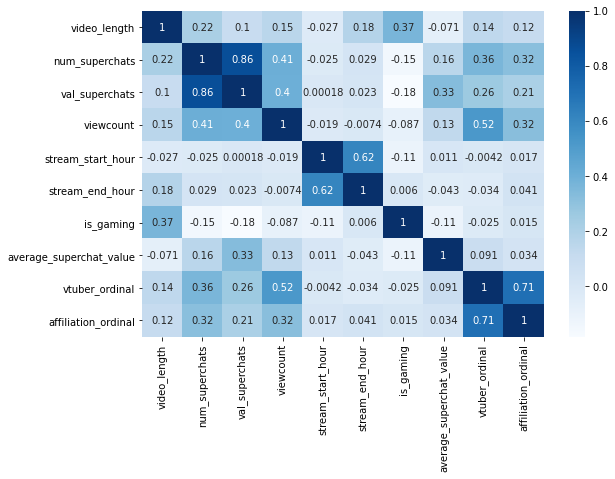

In [12]:
plt.figure(figsize=(9,6))
sns.heatmap(joined.corr(), annot=True, cmap='Blues')
plt.show()

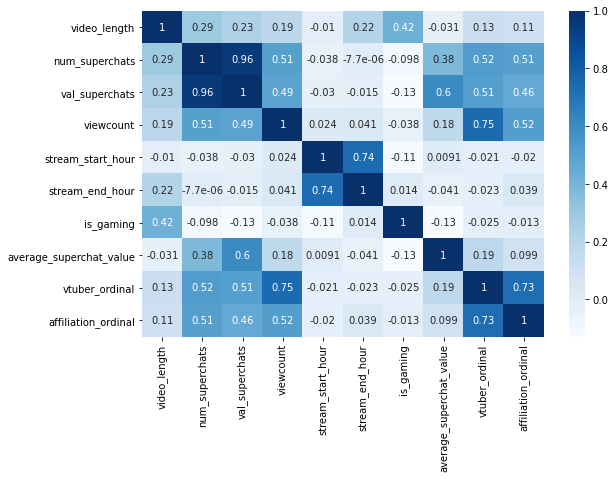

In [13]:
plt.figure(figsize=(9,6))
sns.heatmap(joined.corr("spearman"), annot=True, cmap='Blues')
plt.show()

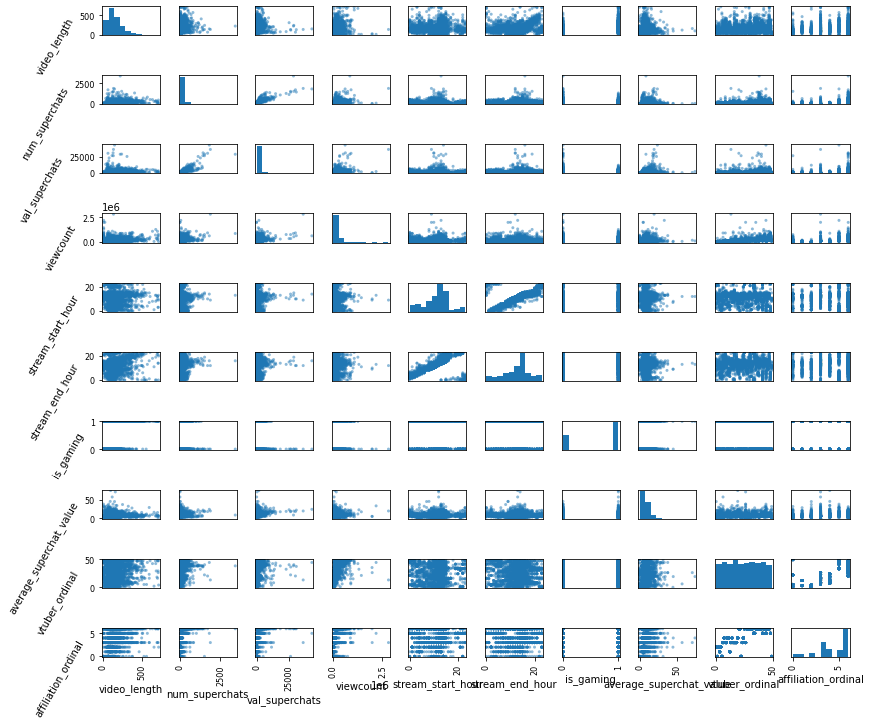

In [14]:
axes = scatter_matrix(joined, figsize=(12, 10))
for ax in axes.flatten():
    ax.yaxis.label.set_rotation(60)
    ax.yaxis.label.set_ha('right')
plt.tight_layout()
plt.show()

We see a few things. Obviously, `num_superchats` and `val_superchats` are highly correlated: the more superchats you have, the more total superchat income you will have. So are `stream_start_hour` and `stream_end_hour`: end hour is almost always after start hour (unless the day wraps around), and since most streams are 1-2 hours long, there's going to be a pretty evident trend. This can actually be seen in the scatter matrix.

Perhaps more of interest is the moderate correlation between the view count and the number and values of superchats (but the much lower correlation between view count and average superchat value), which implies that streams with more viewers get more superchats. This is to be expected, but we will have to see in what way later.

Also of note is the correlation between `is_gaming` and `video_length`. This is also intuitive for those familiar with Vtubers, because longer streams are often video game streams.

The `vtuber_ordinal` is also quite correlated with `num_superchats`, `val_superchats`, and `viewcount`. Of course, we would expect it to be very highly correlated with `viewcount`, since we ranked the ordinal based on subscriber count (and usually, higher subscriber counts mean higher view counts). The other two correlations also make sense: more popular Vtubers probably make more money.

Finally, `affiliation_ordinal` is highly correlated with `vtuber_ordinal` (obviously, since we know which affiliation each Vtuber is in), and thus it is also correlated with the superchats they earn.

While most of the Vtubers are targeted towards a Japanese or South East Asian audience (with similar timezones), there is also Hololive EN in our dataset, targeted towards English speakers (and in particular, North America). Perhaps looking at only these Vtubers might give us some insight.

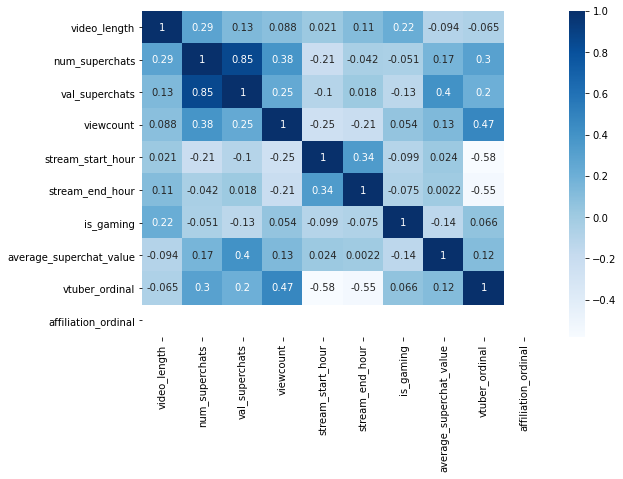

In [15]:
ENGLISH_VTUBERS = ["gawr_gura",
"takanashi_kiara",
"mori_calliope",
"ninomae_inanis",
"watson_amelia"
]

english_vtubers = joined.loc[joined['channel_name'].isin(ENGLISH_VTUBERS)]


plt.figure(figsize=(9,6))
sns.heatmap(english_vtubers.corr(), annot=True, cmap='Blues')
plt.show()

Interestingly, we see that `stream_start_hour` is slightly (negatively) correlated with `num_superchats` and `viewcount` (but not so much `val_superchats`. Perhaps this means that afternoon streams get more views and superchats than morning streams? (Keep in mind hours are measured in UTC). Alternatively maybe one of the Vtubers streams a lot at a certain time and skews the data. Either way, it is worth looking into.

## Correlation between time of day and superchats<a name="tod"></a>

Although the initial correlation matrix didn't really seem to show any correlation between the time of day of streams and the amount of superchats sent, there still might be a relationship. Streams usually last for at least an hour, with many being 6+ hours long, and this data is not initially reflected in our dataframe. So a 12-hour-long stream might have the majority of the superchats concentrated in the evening, and this would not be indicated in the correlation matrix. We did take timestamps of each individual superchat, though, so we can manually plot them out and see.

Unfortunately, I did not scrape individual dollar values of each superchat (only the sum for a given stream), which is sort of a regret but as I am not keen on running the scraping code for another two days we will make do with only the number of superchats for this (rather than dollar amounts). Most superchats average around \\$5-\\$10 anyways, and outlier "red superchats" worth \\$100+ are few and presumably very hard to predict, so this might be for the better anyways. Future work could also scrape individual superchat amounts if desired. 

Note that "time of day" varies around the world. While most of the Vtubers I chose to put in this dataset are tailored for Japanese audiences (and a few Indonesian, but the time zones for that are similar enough), there are also a few (5) targeted towards Western audiences. In this case, I feel it would be prudent to split them into two groups: Hololive EN (tailored for Western audiences), and not Hololive EN (for everyone else). Let's start with the non-EN group for now, since we will have more data there.

{15: 30799, 11: 10680, 2: 2095, 14: 27858, 10: 7658, 13: 25165, 17: 15549, 3: 3815, 6: 4598, 5: 4323, 12: 28380, 9: 6158, 8: 3170, 16: 26075, 19: 8146, 7: 5199, 1: 1084, 0: 2550, 20: 4475, 18: 10434, 4: 2431, 21: 4563, 23: 3492, 22: 2915}


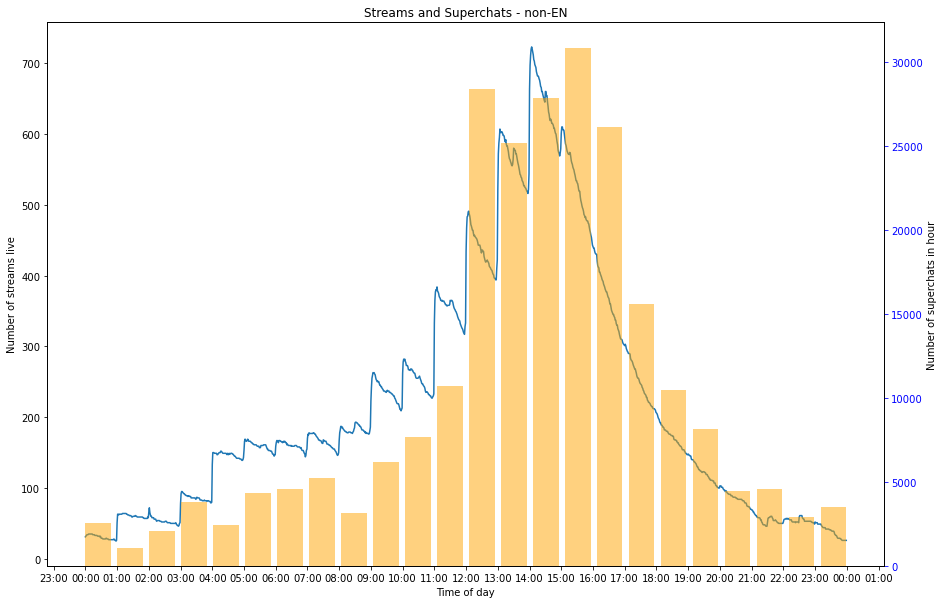

In [75]:
from datetime import time,date, timedelta
# bar chart for all superchats
datetimes = {}
schats = {}
# 00:00 to 23:59

ENGLISH_VTUBERS = ["gawr_gura",
"takanashi_kiara",
"mori_calliope",
"ninomae_inanis",
"watson_amelia"
]

# this is a probably inefficient way of finding times when streams were live
# pick all non-english vtubers (note the ~)
for ind, row in joined.loc[~joined['channel_name'].isin(ENGLISH_VTUBERS)].iterrows():
    
    ct = row["video_start_time"]
    while ct <= row["video_end_time"]:
        # use a random fake date because matplotlib needs an actual date to plot time series
        t = datetime.combine(date(2000, 1, 1), 
                          ct.replace(second=0).time())
        if t in datetimes:
            datetimes[t]+= 1
        else:
            datetimes[t]=1
        ct += timedelta(minutes=1)
        
    
    for i in row["timestamps"]:
        t1 = ct.hour
        if t1 in schats:
            schats[t1]+= 1
        else:
            schats[t1]=1
#print(datetimes)
print(schats)
x,y = zip(*sorted(datetimes.items()))
x2,y2 = zip(*sorted(schats.items()))
fig, ax = plt.subplots(figsize=(15, 10));
ax.plot(x,y)

ax2 = ax.twiny().twinx()
ax2.set_xticks([])
ax2.tick_params('y', colors='b')
#ax2.set_ylim(top=8000)
ax2.bar(x2, y2, color='orange', alpha=0.5)

xfmt = mdates.DateFormatter('%H:%M')
ax.set_title("Streams and Superchats - non-EN")
ax.set_xlabel("Time of day")
ax.set_ylabel("Number of streams live")
ax2.set_ylabel("Number of superchats in hour")
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(xfmt)

There's a lot of information going on with this graph, so let's dissect it.

The line graph in itself is pretty interesting: we can see that on the hour, the number of streams spike. This makes sense because Vtubers often stream on a schedule, and usually start their streams on the hour. We can also see a rapid drop in streams during each hour, presumably as other streams end. It is also interesting to see that most streams happen near 11:00PM JST, which sounds a bit late to be "prime time." However, after I consulted with some other Vtuber fans, they confirmed this was indeed the case due to a combination of Japan's workplace culture resulting in workers getting home late, and poor sleep schedules on many Vtubers' parts. 

We can see that while the amount of superchats do generally follow the times when more Vtubers are streaming, there are some deviations. Between 04:00-11:00 UTC (1:00-8:00PM JST) there are comparatively fewer superchats (as the bars are significantly below the line here). Meanwhile, between 15:00-18:00 UTC (12:00-3:00AM JST) there are comparatively more superchats, with the bars above the line. My hypothesis is that this also has to do with viewer behavior: 1:00-8:00PM JST is the afternoon and early evening, when many workers are still at work or going home, and are not able to catch streams - and thus unable to superchat. On the other hand, dedicated fans (and the ones who are more likely to superchat) are willing to stay up late to watch their Vtubers, so the number of superchats remains high even into the wee hours of the night. Furthermore, western audiences who choose to watch these streamers (which is not an insignficant amount) also may be waking up around this time, increasing the chances of more superchats (Of course, this is just speculation).


{5: 6097, 1: 2661, 4: 4379, 0: 2704, 3: 3950, 6: 4434, 7: 1540, 2: 2065, 14: 554, 22: 2267, 19: 1934, 15: 2457, 21: 1442, 20: 1674, 23: 3306, 18: 620, 16: 3725, 13: 1025, 17: 1095, 8: 338, 12: 100}


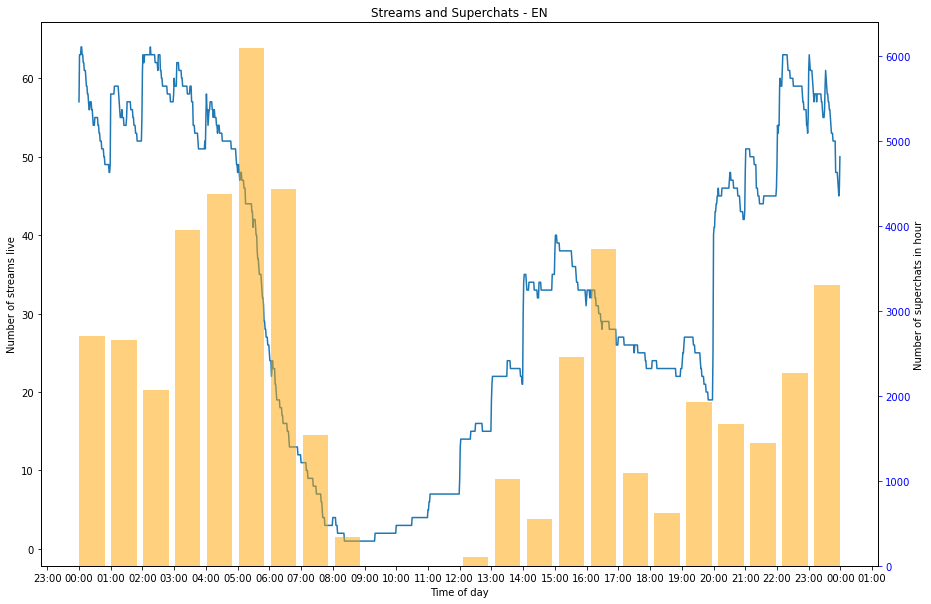

In [74]:
from datetime import time,date, timedelta
# bar chart for all superchats
datetimes = {}
schats = {}
# 00:00 to 23:59

ENGLISH_VTUBERS = ["gawr_gura",
"takanashi_kiara",
"mori_calliope",
"ninomae_inanis",
"watson_amelia"
]

# this is a probably inefficient way of finding times when streams were live
# pick only these 5 vtubers
for ind, row in joined.loc[joined['channel_name'].isin(ENGLISH_VTUBERS)].iterrows():
    
    ct = row["video_start_time"]
    while ct <= row["video_end_time"]:
        # use a random fake date because matplotlib needs an actual date to plot time series
        t = datetime.combine(date(2000, 1, 1), 
                          ct.replace(second=0).time())
        if t in datetimes:
            datetimes[t]+= 1
        else:
            datetimes[t]=1
        ct += timedelta(minutes=1)
        
    
    for i in row["timestamps"]:
        t1 = ct.hour
        if t1 in schats:
            schats[t1]+= 1
        else:
            schats[t1]=1
#print(datetimes)
print(schats)
x,y = zip(*sorted(datetimes.items()))
x2,y2 = zip(*sorted(schats.items()))
fig, ax = plt.subplots(figsize=(15, 10));
ax.plot(x,y)

ax2 = ax.twiny().twinx()
ax2.set_xticks([])
ax2.tick_params('y', colors='b')
#ax2.set_ylim(top=8000)
ax2.bar(x2, y2, color='orange', alpha=0.5)

xfmt = mdates.DateFormatter('%H:%M')
ax.set_title("Streams and Superchats - EN")
ax.set_xlabel("Time of day")
ax.set_ylabel("Number of streams live")
ax2.set_ylabel("Number of superchats in hour")
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(xfmt)

For the EN Vtubers, it is a lot harder to draw conclusions about the data. The main reason for this is that there are only 5 Vtubers considered here (as opposed to 45 in the previous graph), so the individual differences between each one significantly impacts our data (for example, one of them might be earning a lot more superchats than the rest, so they would greatly skew the data). As such, we cannot make any definitive guesses about this data, but I will say that it does seem like most of the superchats come in at around 04:00-06:00 UTC (Which is 12:00-2:00AM Eastern Time, or 9:00-11:00PM Pacific Time), which again reflects our previous hypothesis that more superchats tend to come in during the late evening (relative to the amount of streams that occur during said time).

### Time of Day and Superchats: Summary<a name="tdss"></a>

Although we did not do any quantitative analyses here nor find anything groundbreaking, we did corroborate some concepts that might have seemed like common sense.

* There is a spike in streams on the hour, because that's when streams are scheduled
* Late evening is "prime time" for Vtubers
* Fewer superchats happen during the work day (afternoon)
* More superchats happen during the late evening



### Possible Future Work<a name="tdspfw"></a>

While we qualitatively asserted that the shape of the "superchats per hour" distribution was similar but different to the "streams live at any time" distribution, we did not back this up with numbers. In future work, one could use the 2-sample [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) ([another link for more info](https://www.spss-tutorials.com/spss-kolmogorov-smirnov-test-for-normality/)) to test if the two datasets have the same shape.

## Relationship between view count and superchat earnings<a name="vc"></a>

This might be an interesting plot to see: how does the amount of views of a livestream relate to the actual superchat earnings it generated? We would certainly expect a more popular livestream with more viewers to earn more income, but is this actually what we observe? Is it linear? We can plot view count against superchat earnings for each stream and find out.

Note: View count can be somewhat misleading, since it shows all views including those after the livestream ended. However, the vast majority of views should come during the livestream, so it should not impact our data by much.

Text(0.5, 1.0, 'View Count vs Superchat Earnings (linear scale)')

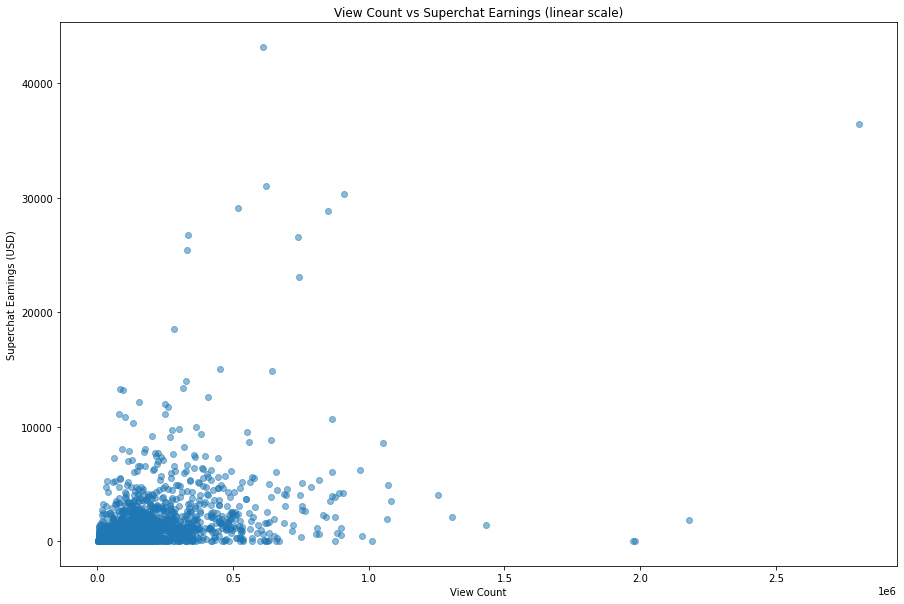

In [189]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(joined["viewcount"] ,joined["val_superchats"], 'o', alpha = 0.5)

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (linear scale)")

Hmmm... It doesn't seem like this graph is very informative. While most of the values are concentrated in relatively low-view, low-earnings videos, there are plenty of videos with much higher earnings and much higher view counts. In this case, it might help to plot each axis on a logarithmic scale. This is called a [log-log plot](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot).

Text(0.5, 1.0, 'View Count vs Superchat Earnings (log-log scale)')

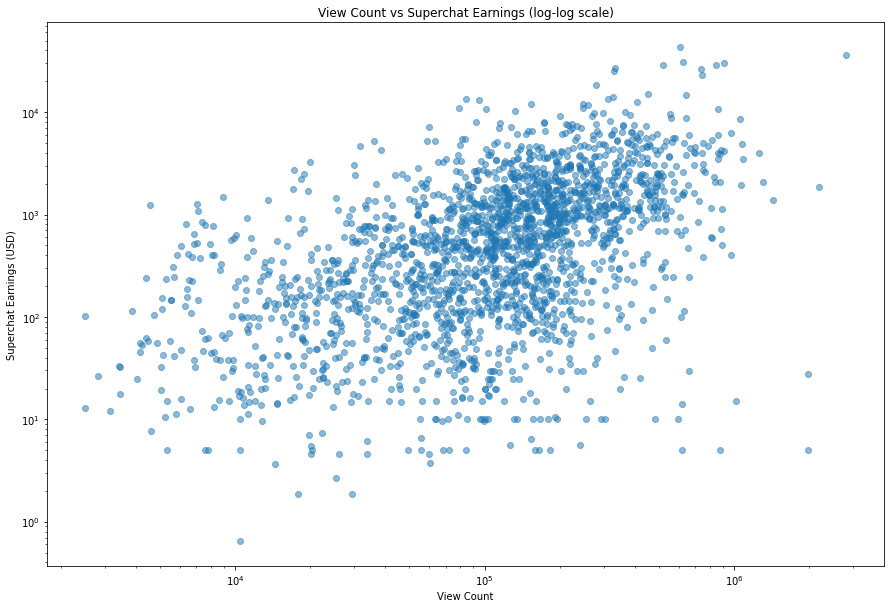

In [190]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(joined["viewcount"] ,joined["val_superchats"], 'o', alpha = 0.5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (log-log scale)")



Now this is very interesting! We can see a few interesting trends here:

* We can sort of see a horizontal line of points near \\$5 superchat earnings, and another horizontal line near \\$10. These probably indicate streams where only 1 or 2 people superchatted during the stream, since buying a membership costs \\$5 USD and a common amount for superchats is 500 yen (which is approximately \\$5 USD as well).
* There certainly seems to be an upwards linear trend on this graph.

Let's try doing a regression on this data to see if we can find out exactly what this trend is!

## The following regression is not what we want. It has been left as a demonstration.<a name="pitfall0"></a>

In [63]:
# use scipy's linear regression, because it gives us a lot of associated statistics

slope, intercept, r_value, p_value, std_err = stats.linregress(joined["viewcount"],joined["val_superchats"])
print('Regression from scipy y=mx+b: \ny = %f x + %f'%(slope, intercept))
print('p-value: %e'%(p_value))
print('r-value: %f'%(r_value))
print('standard error: %f'%(std_err))


Regression from scipy y=mx+b: 
y = 0.005616 x + 310.870274
p-value: 2.826482e-87
r-value: 0.402350
standard error: 0.000271


Well, there certainly seems to be some sort of correlation, as evidenced by the p-value, but the r-value (the correlation coefficient, which essentially tells us how much of the variance is accounted for by our model) leaves a bit to be desired as it is somewhat low. Now, this isn't really a big problem, but let's plot our line of best fit along with our graph to see if it checks out.

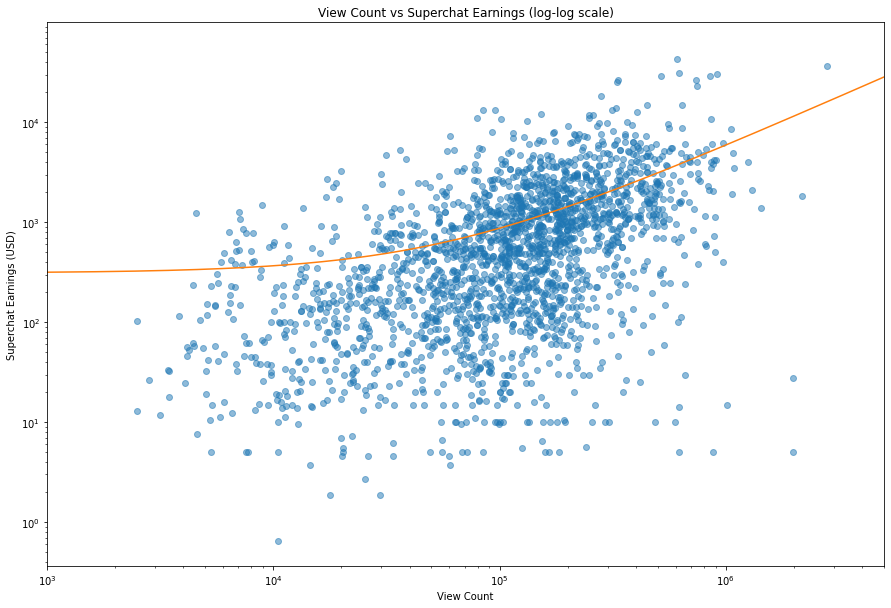

In [64]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xlim([10**3, 5*10**6])
ax.plot(joined["viewcount"] ,joined["val_superchats"], 'o', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (log-log scale)")
x = np.array(range(10**3, 10**7, 5))
ax.plot(x, slope*x + intercept);

plt.show()


Wait a second, that isn't even a straight line! This is because, on a log-log plot, things that appear to be linear are actually monomials of the form $y = ax^k$. Although this regression is _okay_, it definitely isn't what we wanted, and really misses the mark on the lower-view-count, less-superchatted videos.

This illustrates why it is important to double-check our code by plotting it and making sure it actually looks reasonable.

To fix this issue of having a curved line that should be straight, we can either:

* Do some fancy regression using the formula $y = ax^k$ directly and find a and k from that, or
* Take the log of each value on each axis, then perform a linear regression on _those_ values
    - As stated on wikipedia, if $y = ax^k$, we can set $X = \log x$ and $Y = \log y$ to get the relation $Y=kX + \log a$.

The second one should be a lot easier, so let's do that. 


Note that a few streams earned $0 in superchats (exactly 66 of the streams). This is most likely due to one of a few reasons:

* The stream itself was demonetized (due to copyrighted content, etc)
* The streamer was demonetized at the time
* The stream had superchats turned off (for example, if the stream wasn't a normal "livestream" but was created as such in the youtube system)
* The stream was very short

In any case, here are a few ways of dealing with this:

* We can ignore them, since they aren't really representative of the data we're trying to measure.
* We can consider such points as earning 1 cent instead (which, when logged, will give us -2).

These points only constitute 3% of the data anyways, so whether we keep or ignore them should not affect our results. In this case, I chose to ignore them.

In [65]:

temp_df = joined[["viewcount","val_superchats"]]
temp_df = temp_df[temp_df['val_superchats']>0]
temp_df['viewcount'] = temp_df['viewcount'].apply(math.log)
temp_df['val_superchats'] = temp_df['val_superchats'].apply(math.log)

slope, intercept, r_value, p_value, std_err = stats.linregress(temp_df["viewcount"],temp_df["val_superchats"])
print('Regression from scipy y=mx+b: \ny = %f x + %f'%(slope, intercept))
print('p-value: %e'%(p_value))
print('r-value: %f'%(r_value))
print('r^2: %f'%(r_value**2))
print('standard error: %f'%(std_err))


Regression from scipy y=mx+b: 
y = 0.758142 x + -2.713375
p-value: 1.969003e-138
r-value: 0.502581
r^2: 0.252588
standard error: 0.028093


Already, we can see the r-value is higher. This is good, as it indicates it matches up with our data better. Let's plot it:

a =  0.06631264243217902
k =  0.7581418841466804


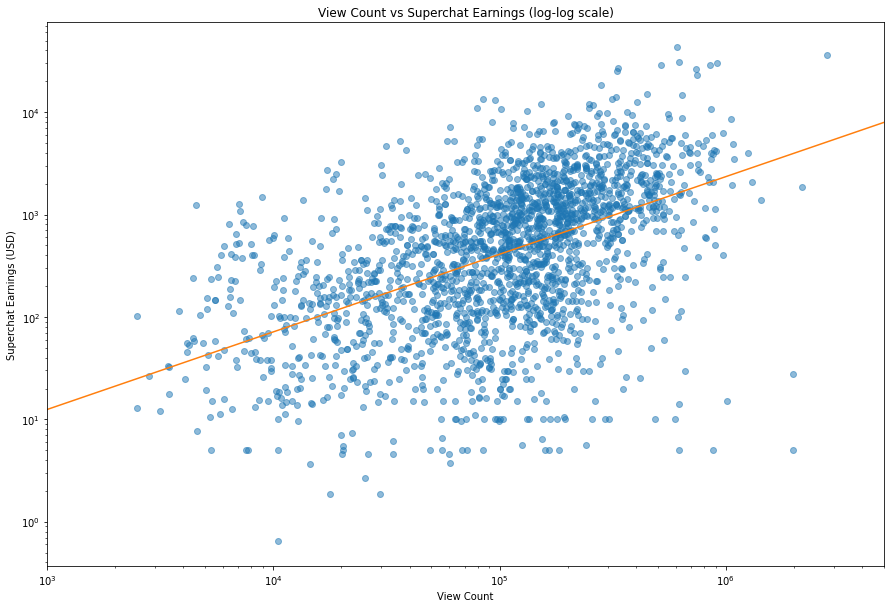

In [250]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xlim([10**3, 5*10**6])
ax.plot(joined["viewcount"] ,joined["val_superchats"], 'o', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (log-log scale)")
x = np.array(range(10**3, 10**7, 5))
# convert the slope and intercept to the relevant values in the right places
print("a = ", math.e**intercept)
print("k = ", slope)
ax.plot(x, (math.e**intercept)*x**slope);

plt.show()



We can also just use the transformed variables themselves. This will be very important later, when we do operations on the data, and especially when we get into the machine learning. One problem with transforming variables is that some data might become less intuitively understandable, but thankfully in our case it is quite easy to transform the data back - just take the `exp` of the transformed view count and superchat earnings.

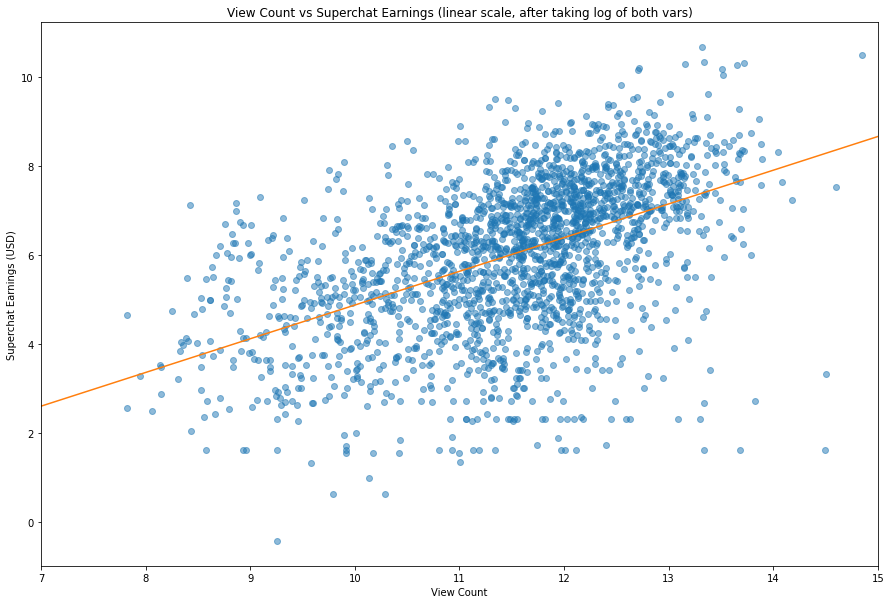

In [251]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xlim([7, 15])
ax.plot(temp_df["viewcount"] ,temp_df["val_superchats"], 'o', alpha=0.5)

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (linear scale, after taking log of both vars)")
x = np.array([i/10.0 for i in range(70,160)])
# convert the slope and intercept to the relevant values in the right places
ax.plot(x, slope*x+intercept);

plt.show()



We can also plot the residuals, to see if our regression is good.

2157


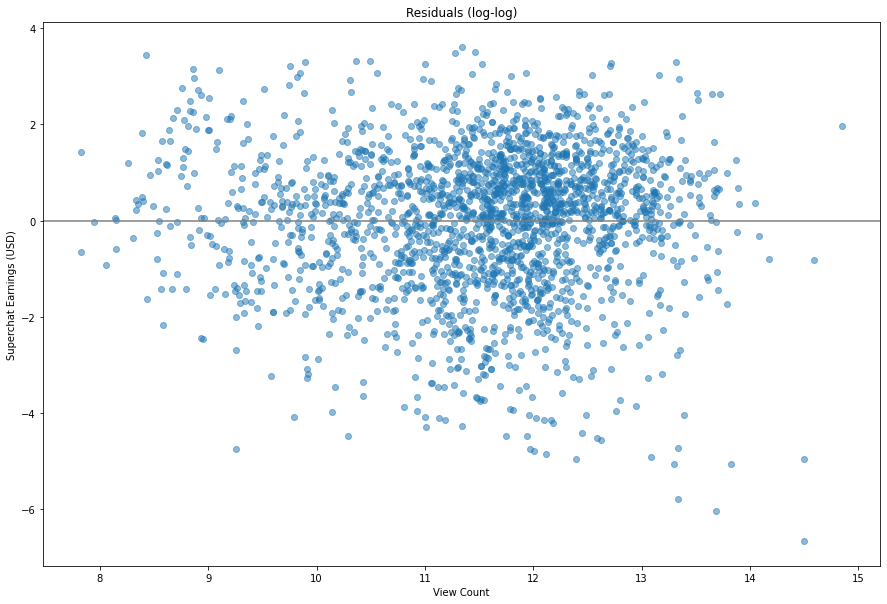

In [252]:
print(len(temp_df))
fig, ax = plt.subplots(figsize=(15, 10))
residuals = []
for ind, row in temp_df.iterrows():
    residuals.append(row["val_superchats"] - slope*row["viewcount"]-intercept)
#print(residuals)
ax.plot(temp_df["viewcount"] ,residuals, 'o', alpha=0.5)
#plt.yscale('symlog')
ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("Residuals (log-log)")
ax.axhline(color="gray")
plt.show()

We can split our residuals into 4 equally-wide groups (based on the view count) and make a violin plot to check for normality.

<AxesSubplot:xlabel='viewcount'>

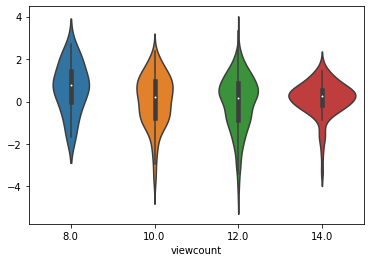

In [462]:
vc2 = temp_df["viewcount"].apply(lambda x: round(x/2, 0)*2)

sns.violinplot(x=vc2, y=residuals)

Great! The residuals seem quite random and somewhat uniformly distributed, so it's probable that our line of best fit is actually quite good (when applied to the log-log data). It does seem like the lower-viewed videos are not as well fitted by our model, as the rest of the data, but only slightly.


------

## Warning! The following section describes a pitfall that you should avoid.<a name="pitfall1"></a>

Next up I will show some code where I screwed up and attempted to take the residuals of the original data, which made the residuals look a lot worse. This actually goes against the whole point of transforming the data in the first place (so that our model fits better). It isn't really relevant anymore, but it's a good learning experience to cover, and we get to talk about a big word: "heteroscedasticity." 

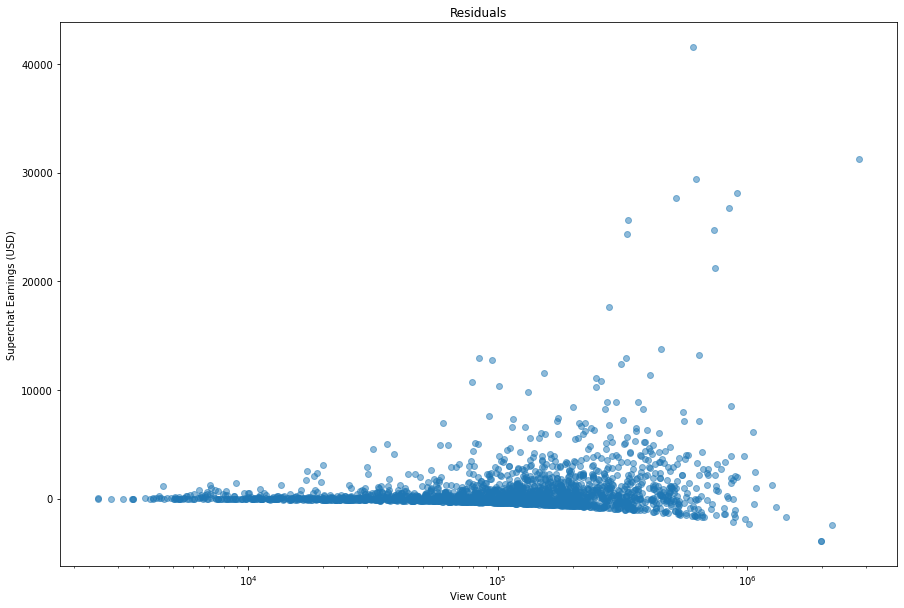

In [253]:
fig, ax = plt.subplots(figsize=(15, 10))
residuals = []
for ind, row in joined.iterrows():
    residuals.append(row["val_superchats"] - (math.e**intercept)*row["viewcount"]**slope)
#print(residuals)
ax.plot(joined["viewcount"] ,residuals, 'o', alpha=0.5)
#plt.yscale('symlog')
ax.set_xscale('log')
ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("Residuals")

plt.show()

Unfortunately, this residual plot exhibits heteroscedasticity, which means that the residuals tend to increase as the prediction increases (as view count increases). This is not necessarily a bad thing, since we're bound to get higher errors with more popular streams just due to the nature of the data, so it might be hard to model. Usually a good way to fix this is transforming the variables (which we did, and that fixes this issue!) 

Note that most of the residuals are above y=0 because our model can only finitely under-value a stream (since there are no negative superchats), but there is no upper limit on how much a video can be superchatted.


> [Here](https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/) is a great resource about the kinds of issues we might see in a residuals plot, including heteroscedasticity.

> [Here](https://rstudio-pubs-static.s3.amazonaws.com/187387_3ca34c107405427db0e0f01252b3fbdb.html) is a resouce for working with and minimizing heteroscedasticity. It involves using generalized least squares instead of ordinary least squares for the regression. We might use it later in this tutorial.

### Back to regularly scheduled data science

-------

Anyways, from our basic regression, it seems like superchat earnings can be roughly modelled by the equation:

$y = 0.0663126 x^{0.758142}$

Where x is the number of viewers and y is the superchat revenue.

## Video game streams - better or worse?<a name="vgs"></a>

Next, let's see if video game streams do better or worse than this average.

Regression from scipy y=mx+b: 
y = 0.957162 x + -5.281012
p-value: 8.104118e-133
r-value: 0.631815
standard error: 0.034170
a =  0.005087282402439689
k =  0.9571623123318653


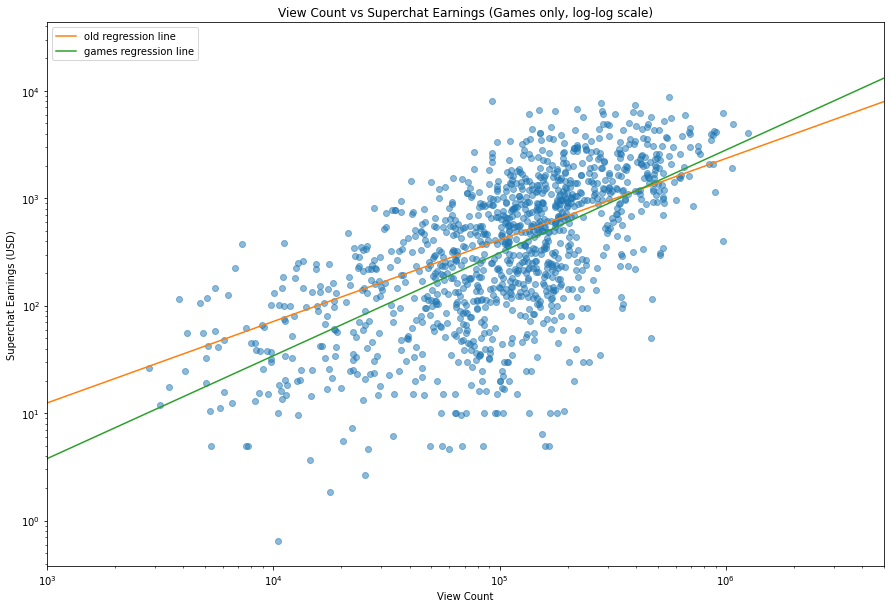

In [254]:
games_only = joined.loc[joined['game_name'] != 'N/A']
temp_df = games_only[["viewcount","val_superchats"]]
temp_df = temp_df[temp_df['val_superchats']>0]
temp_df['viewcount'] = temp_df['viewcount'].apply(math.log)
temp_df['val_superchats'] = temp_df['val_superchats'].apply(math.log)

slope_g, intercept_g, r_value_g, p_value_g, std_err_g = stats.linregress(temp_df["viewcount"],temp_df["val_superchats"])
print('Regression from scipy y=mx+b: \ny = %f x + %f'%(slope_g, intercept_g))
print('p-value: %e'%(p_value_g))
print('r-value: %f'%(r_value_g))
print('standard error: %f'%(std_err_g))


fig, ax = plt.subplots(figsize=(15, 10))
plt.xlim([10**3, 5*10**6])
ax.plot(games_only["viewcount"] ,games_only["val_superchats"], 'o', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (Games only, log-log scale)")
x = np.array(range(10**3, 10**7, 5))
# convert the slope and intercept to the relevant values in the right places
print("a = ", math.e**intercept_g)
print("k = ", slope_g)
ax.plot(x, (math.e**intercept)*x**slope, color='C1', label="old regression line");
ax.plot(x, (math.e**intercept_g)*x**slope_g, color='C2', label="games regression line");
plt.legend(loc='upper left');


plt.show()




Interesting. The r-value is higher (giving us a $r^2 \approx 0.4$), implying that this regression is a better fit for this subset of data than our original regression line was for the entire dataset, but that's probably to be expected. Also, this regression line has a greater slope but lower intercept than the original regression. A possible hypothesis to explain this is that **in general people do not superchat as much on game streams**, as evidenced by the fact that most of the data points have fewer views than the intersection of the two regression lines. However, for popular games that a lot of people enjoy (and thus also watch), they are more willing to shell out money. Of course, checking whether this is the case or not is out of scope of this project.

1183


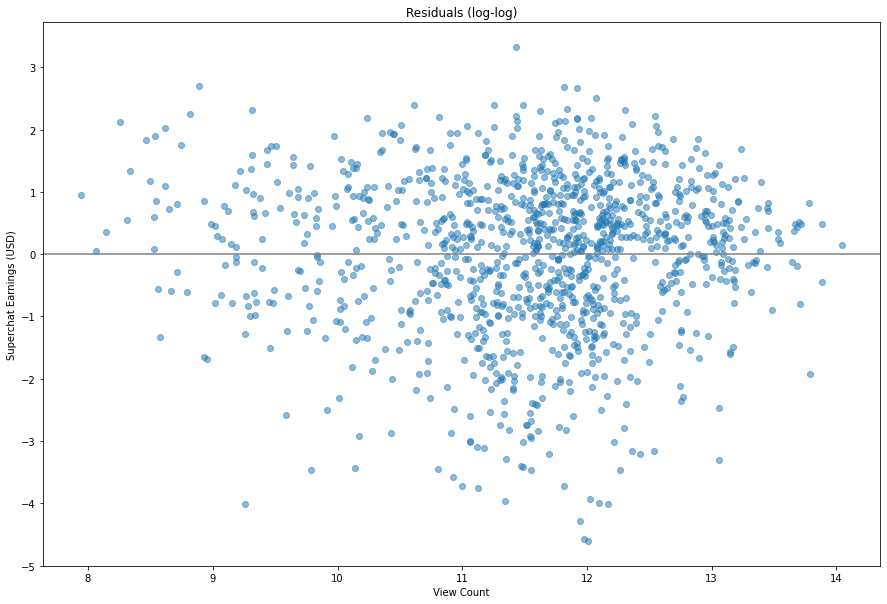

In [255]:
print(len(temp_df))
fig, ax = plt.subplots(figsize=(15, 10))
residuals = []
for ind, row in temp_df.iterrows():
    residuals.append(row["val_superchats"] - slope_g*row["viewcount"]-intercept_g)
#print(residuals)
ax.plot(temp_df["viewcount"] ,residuals, 'o', alpha=0.5)
#plt.yscale('symlog')
ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("Residuals (log-log)")
ax.axhline(color="gray")
plt.show()

Of course, the residuals exhibit similar behavior as before, and there no reason to believe that this is a bad fit. 

Next, let's take a closer look at the most popular games of the past few weeks.

In [223]:
dd = {}
for ind, row in joined.iterrows():
    gn = row["game_name"]
    if gn != 'N/A':
        if gn in dd:
            dd[gn] += 1
        else:
            dd[gn] = 1
            

popular_games = [i for i in dd if dd[i]>=25]
popular_games

['Monster Hunter Rise',
 'Minecraft',
 'Among Us',
 'Apex Legends',
 'Uma Musume Pretty Derby',
 'ARK: Survival Evolved']

Seems like there are 6 games that were streamed over 25 times among all Vtubers in this study. We can plot these all to see if anything interesting is apparent immediately.

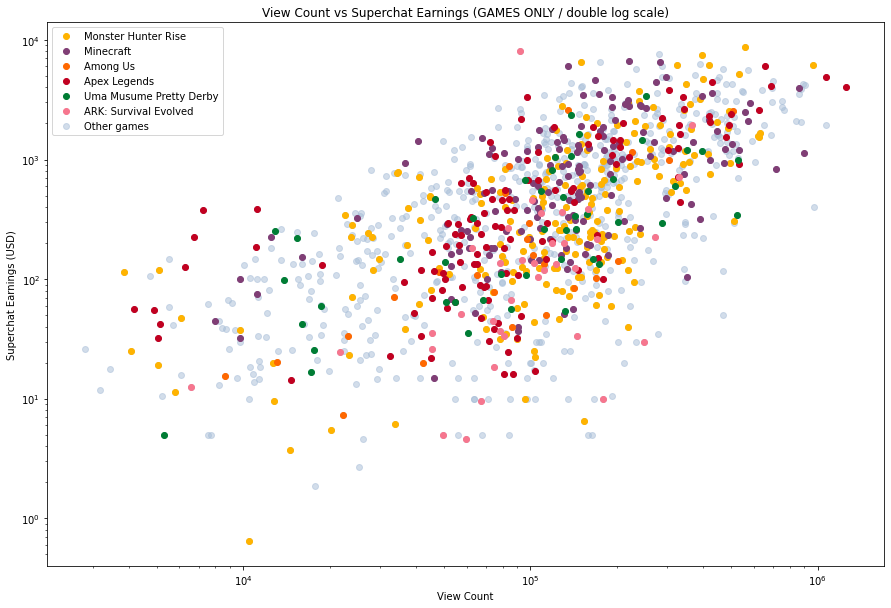

In [224]:
colors_chart = ["#A6BDD7", "#FFB300", "#803E75", "#FF6800", "#C10020", "#007D34", "#F6768E", "#CEA262", "#817066"]

all_games = joined.loc[joined['game_name'] != 'N/A']

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(all_games["viewcount"], all_games["val_superchats"], 'o', color = colors_chart[0], alpha=0.5, label="Other games")
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (GAMES ONLY / double log scale)")
ind = 1
for game in popular_games:
    cur_game = joined.loc[joined['game_name'] == game]
    ax.plot(cur_game["viewcount"], cur_game["val_superchats"], 'o', color = colors_chart[ind], label=game)
    ind += 1
    
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
ax.legend(handles, labels, loc='upper left');
plt.show()

No trends jump out yet. Let's take a closer look at each one, and add regression lines. (Residuals have been omitted for brevity, but if we really wanted to be rigorous we could add those).

a =  0.0022374775669243094
k =  1.0140693210453922
p-value: 5.036286e-26
r-value: 0.641997
standard error: 0.083571
num_points: 212


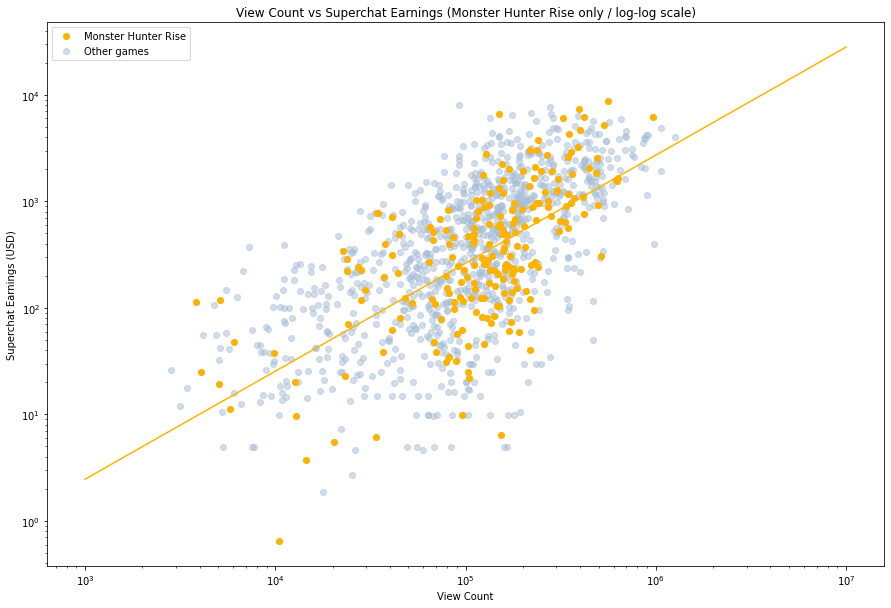

a =  0.024647340585237255
k =  0.8541428920820173
p-value: 1.186951e-14
r-value: 0.571653
standard error: 0.099767
num_points: 153


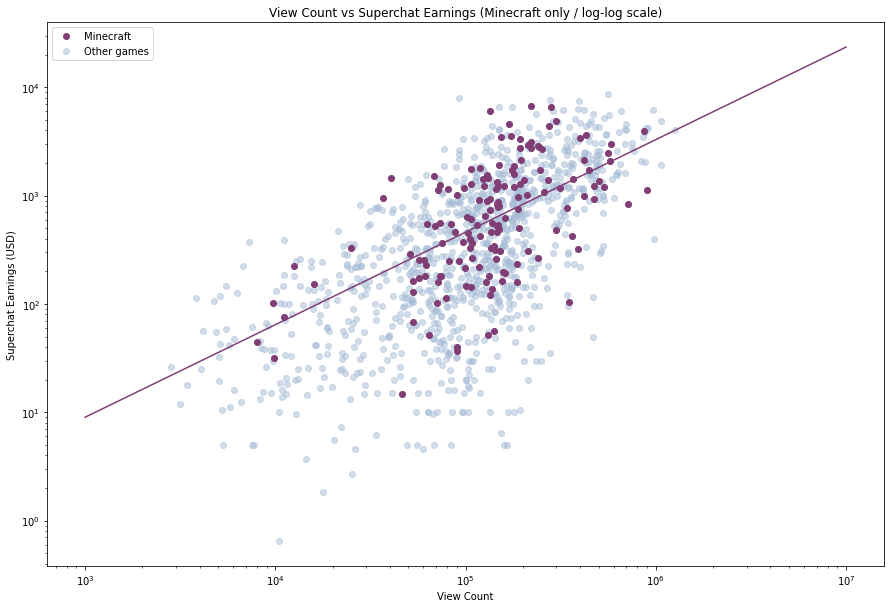

a =  9.198275724464118e-05
k =  1.2590787495197502
p-value: 1.320476e-05
r-value: 0.765291
standard error: 0.225781
num_points: 24


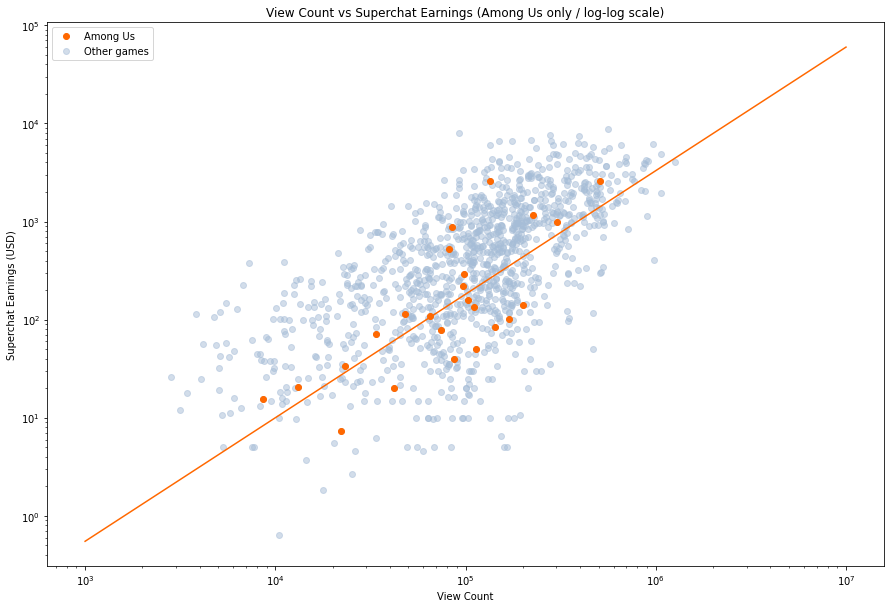

a =  0.010261389553868317
k =  0.9040575053393242
p-value: 5.337854e-17
r-value: 0.660434
standard error: 0.092680
num_points: 125


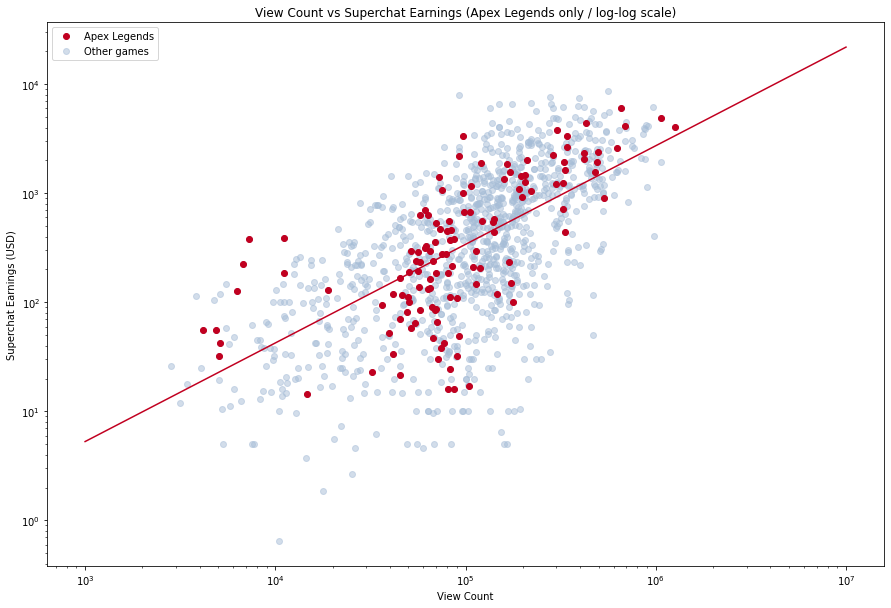

a =  0.007836455982409087
k =  0.9045304900931068
p-value: 4.767082e-08
r-value: 0.698563
standard error: 0.138118
num_points: 47


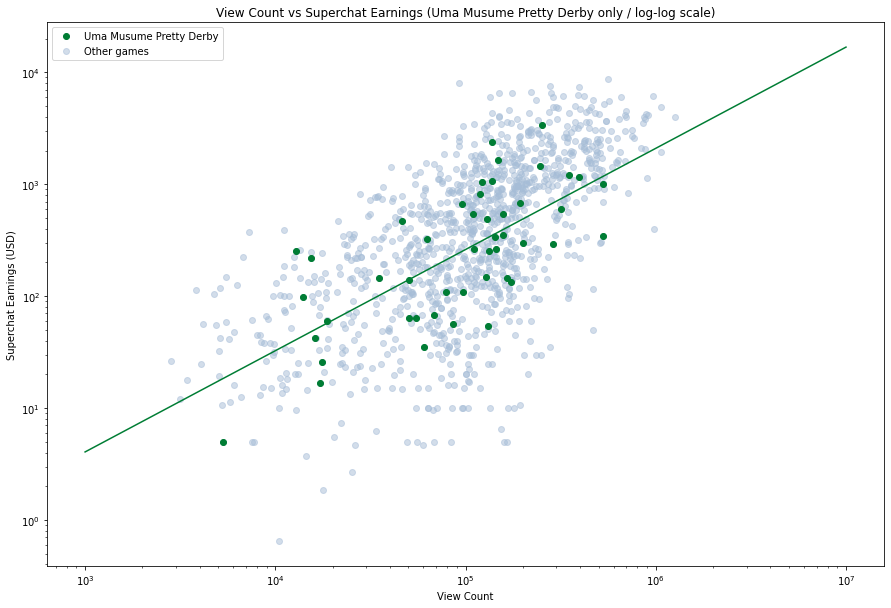

a =  0.00029844862524387765
k =  1.1028099912192952
p-value: 1.710327e-03
r-value: 0.504334
standard error: 0.323824
num_points: 36


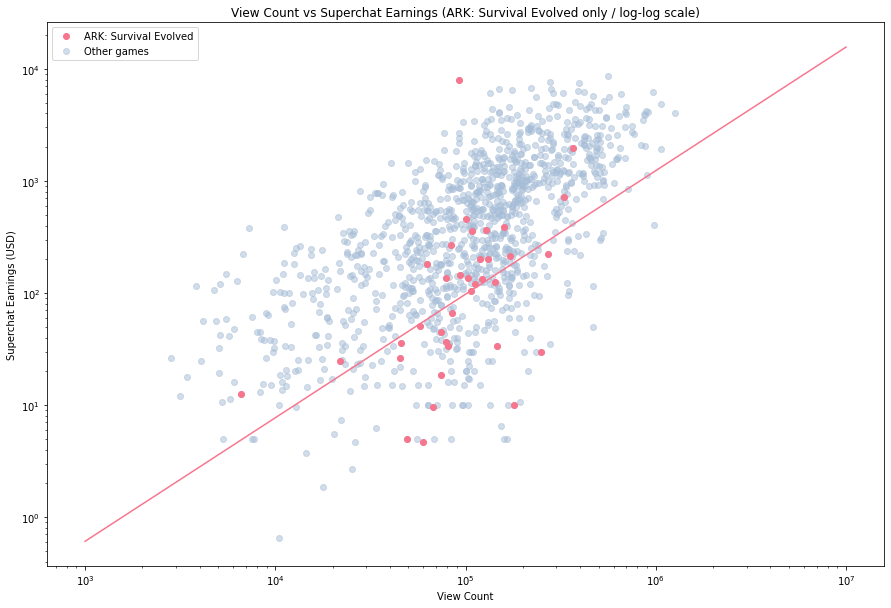

In [262]:
ind = 1
regs = []
x = np.array(range(10**3, 10**7, 5))
for game in popular_games:
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(all_games["viewcount"], all_games["val_superchats"], 'o', color = colors_chart[0], alpha=0.5, label="Other games")
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlabel("View Count")
    ax.set_ylabel("Superchat Earnings (USD)")
    ax.set_title("View Count vs Superchat Earnings ({0} only / log-log scale)".format(game))


    cur_game = joined.loc[joined['game_name'] == game]
    
    temp_cg_df = cur_game[["viewcount","val_superchats"]]
    temp_cg_df = temp_cg_df[temp_cg_df['val_superchats']>0]
    temp_cg_df['viewcount'] = temp_cg_df['viewcount'].apply(math.log)
    temp_cg_df['val_superchats'] = temp_cg_df['val_superchats'].apply(math.log)

    slope_t, intercept_t, r_value_t, p_value_t, std_err_t = stats.linregress(temp_cg_df["viewcount"],temp_cg_df["val_superchats"])
    print("a = ", math.e**intercept_t)
    print("k = ", slope_t)
    print('p-value: %e'%(p_value_t))
    print('r-value: %f'%(r_value_t))
    print('standard error: %f'%(std_err_t))
    print('num_points: %d'%(len(temp_cg_df)))
    
    ax.plot(x, (math.e**intercept_t)*x**slope_t, color=colors_chart[ind]);
    regs.append((intercept_t,slope_t))
    
    ax.plot(cur_game["viewcount"], cur_game["val_superchats"], 'o', color = colors_chart[ind], label=game)
    ind += 1
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[1:] + [handles[0]]
    labels = labels[1:] + [labels[0]]
    ax.legend(handles, labels, loc='upper left');
    plt.show()


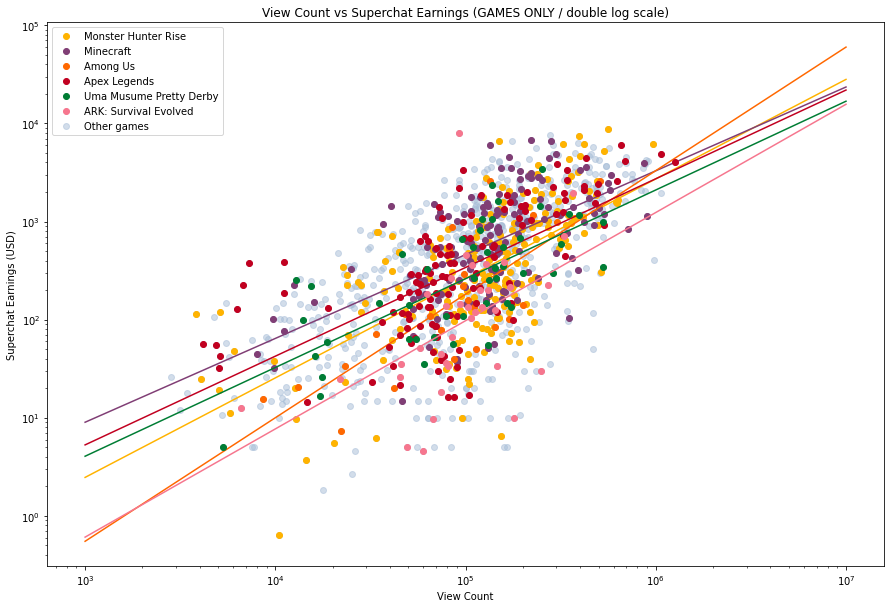

In [264]:
colors_chart = ["#A6BDD7", "#FFB300", "#803E75", "#FF6800", "#C10020", "#007D34", "#F6768E", "#CEA262", "#817066"]

all_games = joined.loc[joined['game_name'] != 'N/A']

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(all_games["viewcount"], all_games["val_superchats"], 'o', color = colors_chart[0], alpha=0.5, label="Other games")
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel("View Count")
ax.set_ylabel("Superchat Earnings (USD)")
ax.set_title("View Count vs Superchat Earnings (GAMES ONLY / double log scale)")
ind = 1
for game in popular_games:
    cur_game = joined.loc[joined['game_name'] == game]
    ax.plot(cur_game["viewcount"], cur_game["val_superchats"], 'o', color = colors_chart[ind], label=game)
    ax.plot(x, (math.e**regs[ind-1][0])*x**regs[ind-1][1], color=colors_chart[ind]);
    ind += 1
    
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]



ax.legend(handles, labels, loc='upper left');
plt.show()

While it does seem like some of these games have significantly different slopes (in particular, the Among Us) streams, it is important to note that there were only 24 points used for this stream's regression, so it's highly likely that the regression for this is inaccurate. Overall, we're starting to get too few data points in each category to be reliable, so we should probably end the analysis here for views vs. superchat earnings, and conclude that individual game titles make little difference on superchat earnings.

Note: I talked with a Vtuber fan friend of mine who said that Among Us streams tend to not get many superchats. This seems to be corroborated by the data.

## Views vs Superchats Findings, summarized<a name="vcsumm"></a>

* There is a monomial relationship between view count and superchat earnings
    $y = 0.0663126 x^{0.758142}$
    where x is the number of viewers and y is the superchat revenue. This is certainly reasonable: while more viewers means you're more likely to make money, during a smaller stream individual people might feel more compelled to superchat because they feel they make a difference. When everyone else is also superchatting one might be less inclined to do so; hence the sub-linear trend.
    * We found an $r^2$ value of about $0.2525$.
    
* Game streams tend to follow a more linear relationship, with an exponent around 0.96. I speculate this might be because during eventful games - particularly those that many people enjoy - when an impactful situation occurs (winning a game, getting kills, rolling gacha \[loot boxes\]) people are more likely to superchat. This could be less affected by the "diffusion of responsibility" effect mentioned previously.

* Not necessarily a significant difference in superchats by individual games.



# Machine Learning<a name="ml"></a>

Let's see if machine learning can use multiple of the factors we've looked at and seen some correlation with to accurately model the amount of superchat earnings a stream will make! We'll use `video_length`, `viewcount` (normalized), `is_gaming`, and `vtuber_ordinal` to predict `val_superchats` (normalized).

In [81]:
import sklearn.linear_model

joined.head()
to_ml = joined[["video_length","val_superchats", "viewcount", "is_gaming", "vtuber_ordinal", "affiliation_ordinal"]]

# normalize the viewcount and val_superchats
to_ml = to_ml[to_ml['val_superchats']>0]
to_ml['viewcount'] = to_ml['viewcount'].apply(math.log)
to_ml['val_superchats'] = to_ml['val_superchats'].apply(math.log)
# i normalized this ordinal, but since this is just a categorical variable normalizing it doesn't matter for our regression
to_ml['vtuber_ordinal'] = to_ml['vtuber_ordinal']/45

# the value we want to predict
y = to_ml['val_superchats']

# everything else
X = to_ml.drop('val_superchats',axis=1)
X.head()


,video_length,viewcount,is_gaming,vtuber_ordinal,affiliation_ordinal
0,141.150000,11.271172,1,1.0,6
1,131.866667,12.019695,0,1.0,6
2,171.683333,12.130708,1,1.0,6
3,33.783333,11.649849,0,1.0,6
4,59.600000,11.228930,0,1.0,6


In [40]:
y

0       3.444930
1       6.736678
2       6.535469
3       4.568066
4       2.706048
          ...   
2218    4.250601
2219    8.550701
2220    3.264271
2221    4.575987
2222    4.397564
Name: val_superchats, Length: 2157, dtype: float64

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# stratify our training data, so that we train on near-equal amounts of each vtuber
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['vtuber_ordinal'], random_state = 2)

# use training data to fit regression
linreg = sklearn.linear_model.LinearRegression()
linreg.fit(X_train, y_train)

print(linreg.coef_)
print(linreg.intercept_)

# predict data on our testing and training data
y_test_reg = linreg.predict(X_test)
y_train_reg = linreg.predict(X_train)

# check accuracy
accuracy_train = linreg.score(X_train, y_train)
accuracy_test = linreg.score(X_test, y_test)


print("Regression r^2 on training data: %f"%accuracy_train)
print("Regression r^2 on test data: %f"%accuracy_test)

[ 0.00328273  0.31500079 -0.78465816  1.08290011  0.14428761]
1.1508926086303992
Regression r^2 on training data: 0.355851
Regression r^2 on test data: 0.351916


Recall the $r^2$ of our simpler, non-ML regression earlier (based only off view count) had a $r^2$ of about 0.25 (and it used the entire dataset!) While the $r^2$ of our new model is still somewhat low, at ~0.35, it is certainly better than before, and it only used 75% of the data to train on. We would not expect a very high score anyways, since human behavior is unpredictable. Overall, our machine learning model is indeed a better model for Vtuber earnings.

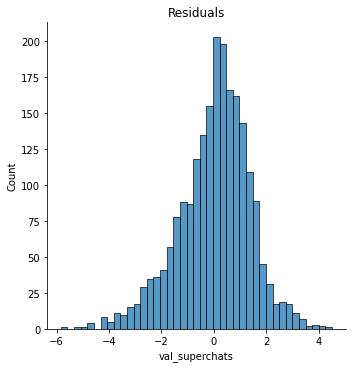

In [48]:
y_hat = linreg.predict(X)
sns.displot(y - y_hat)
plt.title("Residuals");

Our residuals look vaguely normal and are generally symmetric around 0, so this is good too.

Perhaps more importantly, if we drop the `viewcount` column (since we don't necessarily know how many viewers are going to watch a stream beforehand), we can still get a meaningful regression.

In [49]:
X_2 = to_ml.drop('val_superchats',axis=1).drop('viewcount',axis=1)
X_2.head()

,video_length,is_gaming,vtuber_ordinal,affiliation_ordinal
0,141.150000,1,1.0,6
1,131.866667,0,1.0,6
2,171.683333,1,1.0,6
3,33.783333,0,1.0,6
4,59.600000,0,1.0,6


In [52]:
# stratify our training data, so that we train on near-equal amounts of each vtuber
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, stratify=X_2['vtuber_ordinal'], random_state = 2)

# use training data to fit regression
linreg_2 = sklearn.linear_model.LinearRegression()
linreg_2.fit(X_train_2, y_train_2)

print(linreg_2.coef_)
print(linreg_2.intercept_)

# predict data on our testing and training data
y_test_reg_2 = linreg_2.predict(X_test_2)
y_train_reg_2 = linreg_2.predict(X_train_2)

# check accuracy
accuracy_train_2 = linreg_2.score(X_train_2, y_train_2)
accuracy_test_2 = linreg_2.score(X_test_2, y_test_2)


print("Regression r^2 on training data: %f"%accuracy_train_2)
print("Regression r^2 on test data: %f"%accuracy_test_2)

[ 0.00373746 -0.82975032  1.89499113  0.14987797]
4.2684802213273265
Regression r^2 on training data: 0.337681
Regression r^2 on test data: 0.335115


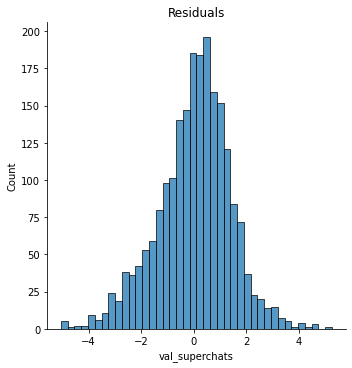

In [53]:
y_hat_2 = linreg_2.predict(X_2)
sns.displot(y - y_hat_2)
plt.title("Residuals");

So even with only knowledge of `video_length`, `is_gaming`, `vtuber_ordinal`, and `affiliation_ordinal` (essentially, which Vtuber one is and what group they belong to), we can get almost as good of a regression! This is important because a Vtuber might be able to estimate how much they will make, given what topic/game they plan on streaming and how long they want to stream for.

# Takeaways<a name="summ"></a>

While we weren't able to make a one-size-fits-all formula to model the amount of money a Vtuber will make from superchats, we gained a lot of insight into the nature of superchat earnings.

* Peak hours are near midnight of whatever the target audience is
* Fewer superchats come in during workday hours, and more come in after midnight (relative to the number of streams live at the time)
* View count and superchat earnings are polynomially correlated (generally with degree less than 1); over the streams we analyzed the correlation was $y = 0.0663126 x^{0.758142}$ (y is superchat revenue, x is number of views)
    * This simple regression had $r^2 \approx 0.25$
    * Video game streams generally make less money than other streams, but potentially make more with higher views (had a higher exponent on x)
* We were able to train a model using a Vtuber's affiliation, ordinal ranking (based off subscriber count), the length of their stream, if it was gaming or not, and (optionally) a view count to somewhat accurately predict the superchat earnings for the video
    * Machine learning regression had $r^2 \approx 0.35$

Hopefully you found this interesting and learned something new!


# Future Possibilities<a name="pfw"></a>

* Does the day of the week of the stream affect superchat earnings? This is very similar to the things done already, and can be done with the data I collected. I did not do this because I did not want to make this tutorial any longer than it already is.
* Do more research into individual superchat sizes, and viewer nationalities based on currency data. Sadly I did not collect this information.
* What is the impact of collaborations or special event streams (milestones, outfit reveals, etc) on superchats? While I left a few such streams in and they seem to fit with the log-log model made in the Exploratory Data Analysis section (since they have a lot more viewers and a lot more superchats), it would be interesting to see data studying just these special streams. I did not have a way of tagging streams as such, and it would probably require parsing video titles/descriptions or manual tagging. 